In [1]:
import sys, os 
#sys.path.insert(0,r"C:\Users\labadmin\Documents\suite2p")
#sys.path.insert(0,r"C:\Users\labadmin\Documents\rastermap")
import numpy as np 
import pandas as pd
from src import utils, plots, redcells
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

# First day all rewarded

In [394]:
m1 = utils.load_mouse('VG11','2024_10_15', '4', load_neurons=True, interp_behav=True, load_retinotopy=True)
frameselector = utils.get_frameselector(m1)
istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m1.frameselector = (frameselector.reset_index()
      .rename(columns = {'index':'frame'})
      .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
      .set_index('frame'))
m1._spks = m1._spks[m1._snr>=.25]
m1._xpos = m1._xpos[m1._snr>=.25]
m1._ypos = m1._ypos[m1._snr>=.25]
m1._iplane = m1._iplane[m1._snr>=.25]
m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = True, corridor_length=400)

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_10_15\4
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_10_15_4.mat not found, trying with fname: VG11_2024_10_15_4.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [06:04<00:00, 18.25s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_10_15_4_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
39 11681
interpolating 25932 neurons, 11643 frames to
the vector of distance with shape: (11643,)
neurons: 25932, trials: 345, corridor length: 400


In [395]:
m1.iarea = m1.iarea[m1._snr>=.25]
m1.iregion = m1.iregion[m1._snr>=.25]
m1.xy_t = m1.xy_t[m1._snr>=.25]

In [396]:
m1.trial_dict = utils.get_trialno_bytype(m1.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


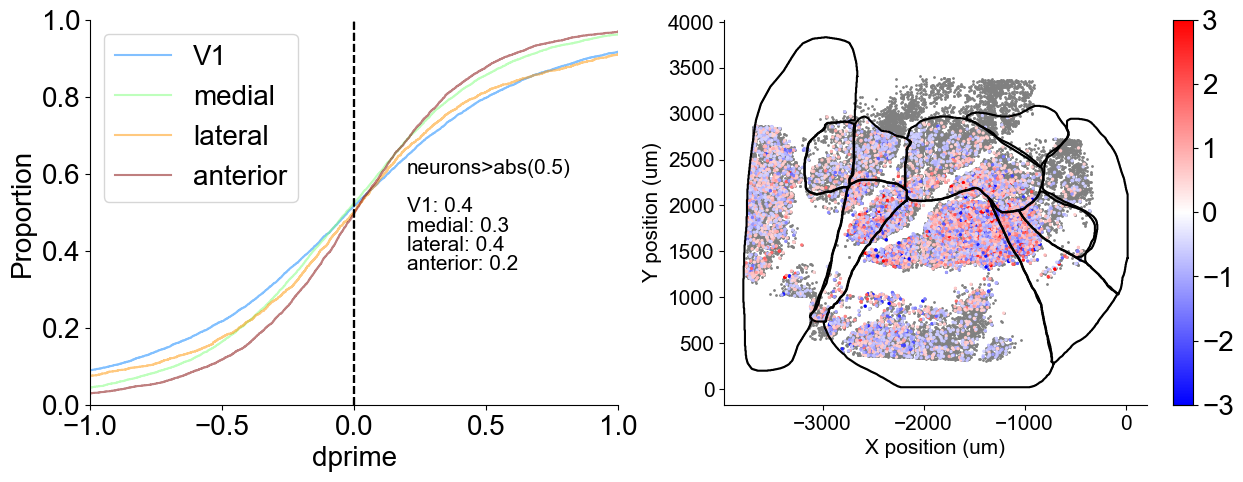

In [401]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 0.5
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],1)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-1,1)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

In [402]:
def get_dp_thresholds(train_dp, tsh):
    if tsh > 1: # in the case we want to use a percentile
        pstv_tsh = np.percentile(train_dp, tsh) #positive threshold
        ngtv_tsh = np.percentile(train_dp, 100-tsh)
    else: # in the case we want to use a fixed value (needs to be a number lower than 1)
        pstv_tsh = tsh
        ngtv_tsh = -tsh
    return pstv_tsh, ngtv_tsh

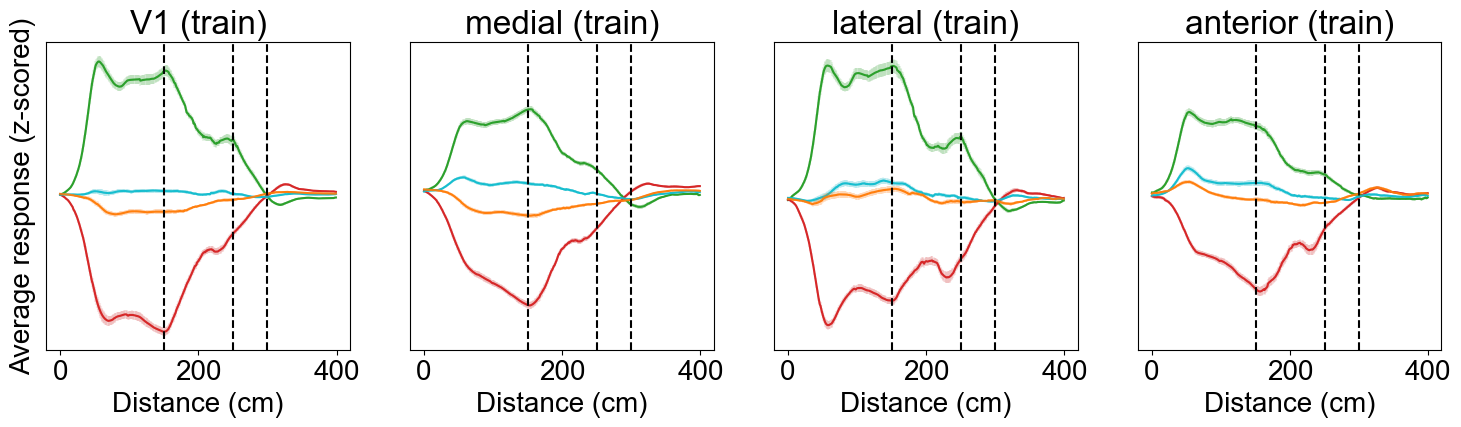

In [404]:
from scipy.stats import sem
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
        else:
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (train)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa != 0:
        ax[indexa].set_yticks([])
    else:
        ax[indexa].set_ylabel('Average response (z-scored)')


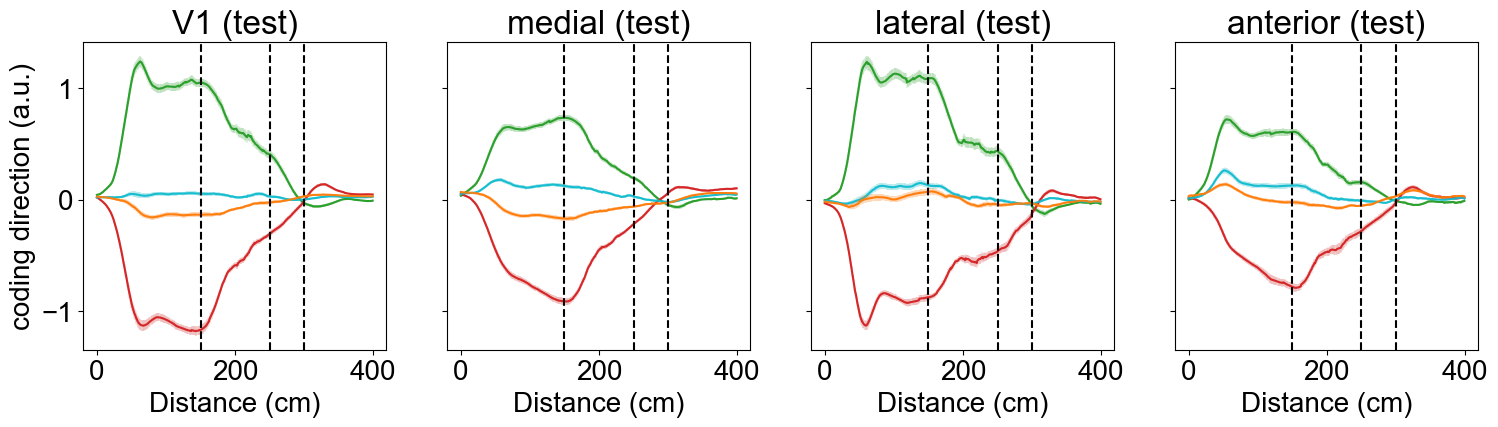

In [407]:
from scipy.stats import sem
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
        else:
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('coding direction (a.u.)')

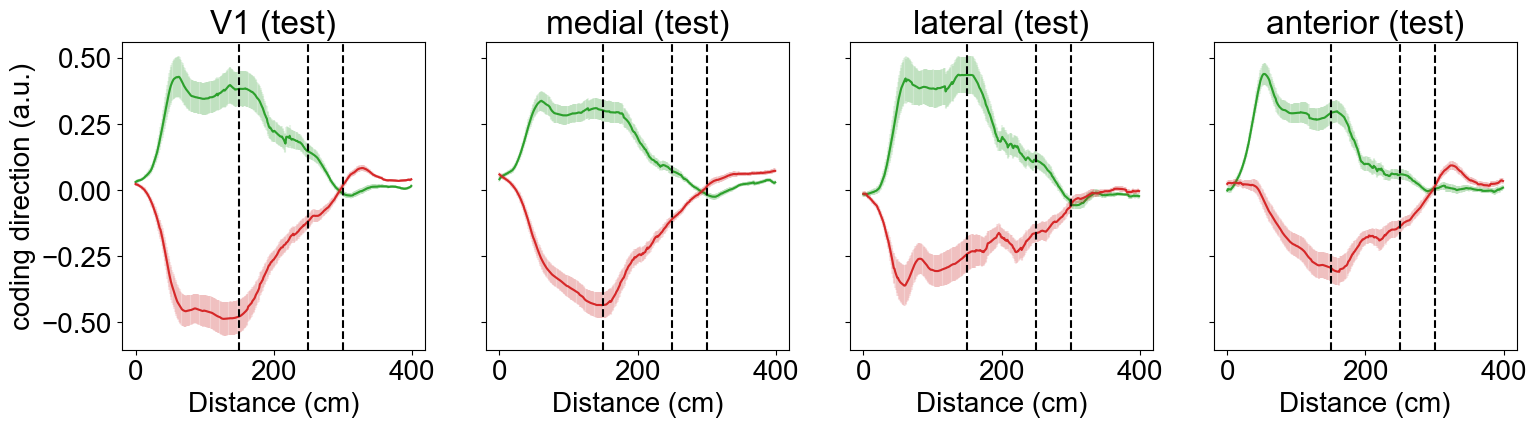

In [408]:
all_rew = np.concatenate([m1.trial_dict['rewarded'][1::2], m1.trial_dict['rewarded test']])
all_nrew = np.concatenate([m1.trial_dict['non rewarded'][1::2], m1.trial_dict['non rewarded test']])

all_dict = {
    "rewarded": all_rew,
    "non rewarded": all_nrew,
}
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(all_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('coding direction (a.u.)')

# concatenating all instances in the category

In [409]:
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False, concatenate=True)

dprime saved in MouseObject.train_dp (neurons) using even trials


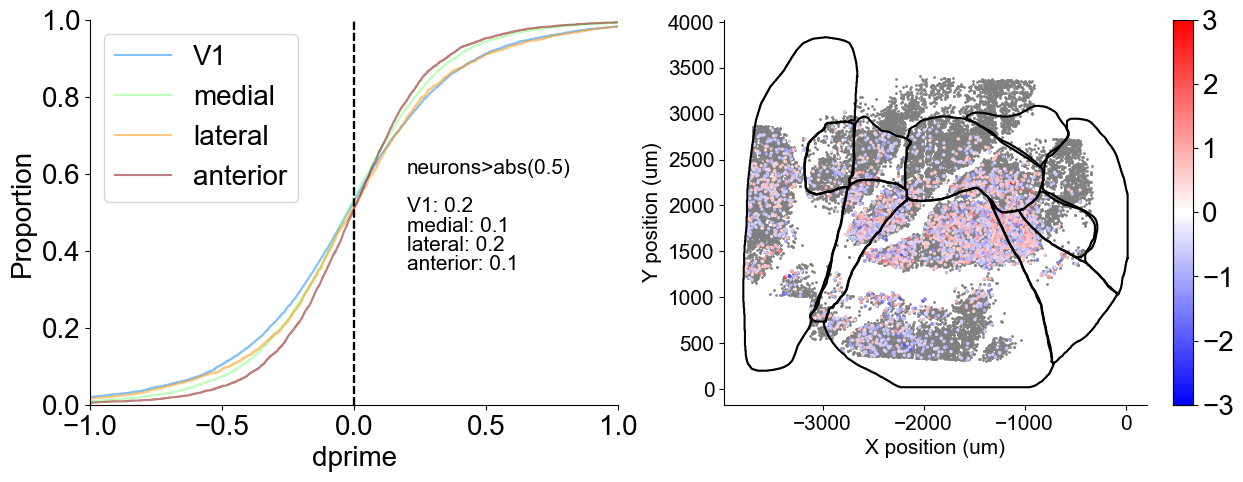

In [410]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 0.5
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],1)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-1,1)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

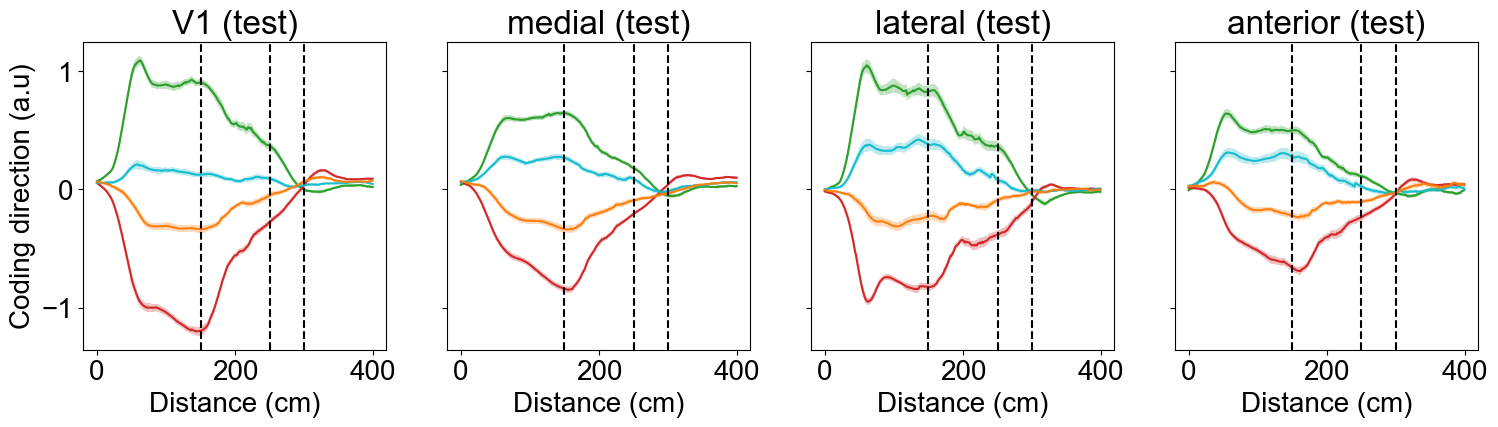

In [411]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')


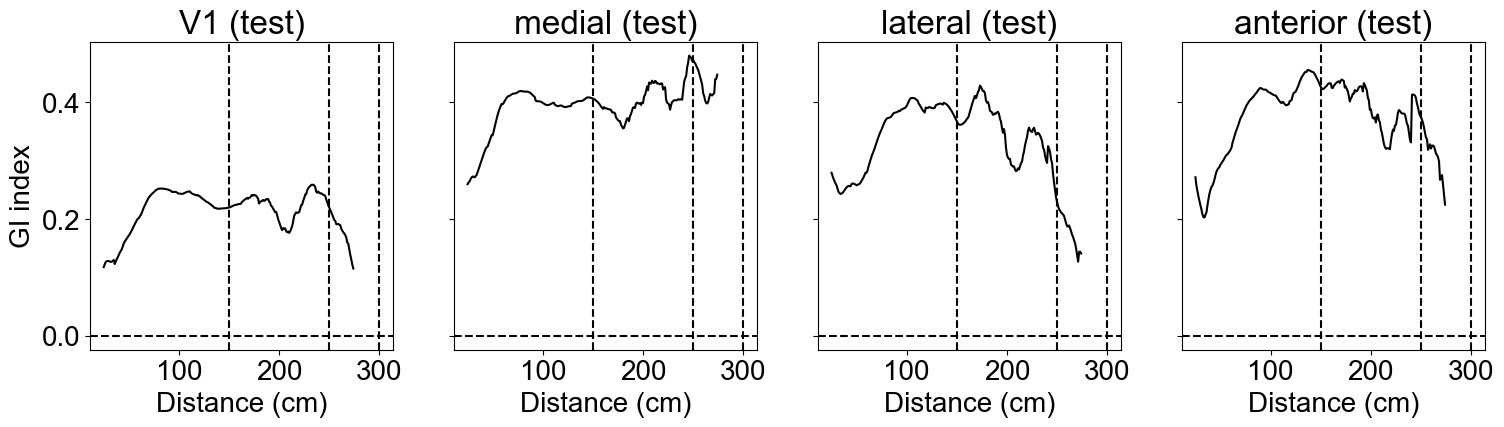

In [412]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((len(areas), 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            avg_resp[i_t] = avg_dir_plot.mean(0)
    gi_index = (avg_resp[2] - avg_resp[3]) / (avg_resp[0] - avg_resp[1]) 
    ax[indexa].plot(np.arange(25,275), gi_index[25:275], color = 'k', linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].axhline(y=0, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('GI index')


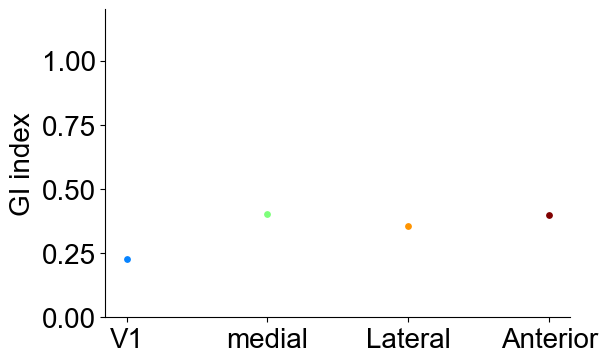

In [413]:
fig, ax = plt.subplots(1,1, figsize=(6,4), sharey=True)
avg_resp = np.empty((len(areas), 400))
gi_index_allrew = np.empty((len(areas), 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            avg_resp[i_t] = avg_dir_plot.mean(0)
    gi_index_allrew[indexa] = (avg_resp[2] - avg_resp[3]) / (avg_resp[0] - avg_resp[1]) 
    gi_a = gi_index_allrew[indexa,:]
    ax.errorbar(indexa, gi_a[50:250].mean(), sem(gi_a[50:250]), color = area_dict[area])
    ax.scatter(indexa, gi_a[50:250].mean(), color = area_dict[area],s=15)
    ax.set_xticks([0,1,2,3],["V1","medial", "Lateral", "Anterior"])
    ax.set_ylim(0,1.2)
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax.set_ylabel('GI index')
sns.despine()

# Second day, first training session:

In [414]:
m1 = utils.load_mouse('VG11','2024_10_16', '2', load_neurons=True, interp_behav=True, load_retinotopy=True)
frameselector = utils.get_frameselector(m1)
istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m1.frameselector = (frameselector.reset_index()
      .rename(columns = {'index':'frame'})
      .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
      .set_index('frame'))
m1._spks = m1._spks[m1._snr>=.25]
m1._xpos = m1._xpos[m1._snr>=.25]
m1._ypos = m1._ypos[m1._snr>=.25]
m1._iplane = m1._iplane[m1._snr>=.25]
m1.iarea = m1.iarea[m1._snr>=.25]
m1.iregion = m1.iregion[m1._snr>=.25]
m1.xy_t = m1.xy_t[m1._snr>=.25]
m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = True, corridor_length=400)

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_10_16\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_10_16_2.mat not found, trying with fname: VG11_2024_10_16_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [06:40<00:00, 20.00s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_10_16_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
37 10871
interpolating 29324 neurons, 10835 frames to
the vector of distance with shape: (10835,)
neurons: 29324, trials: 399, corridor length: 400


In [415]:
m1.trial_dict = utils.get_trialno_bytype(m1.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


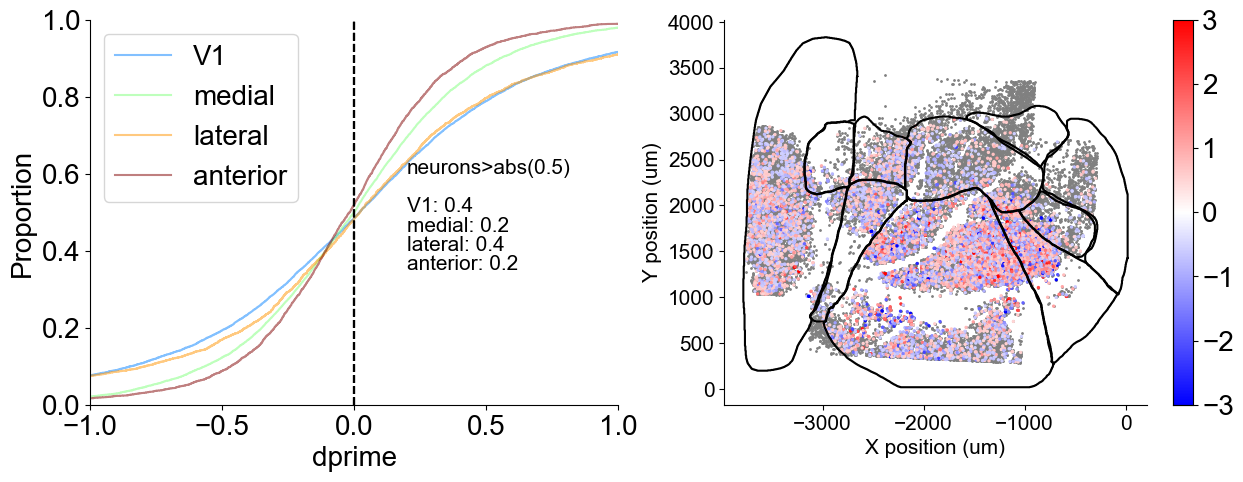

In [416]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 0.5
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],1)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-1,1)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

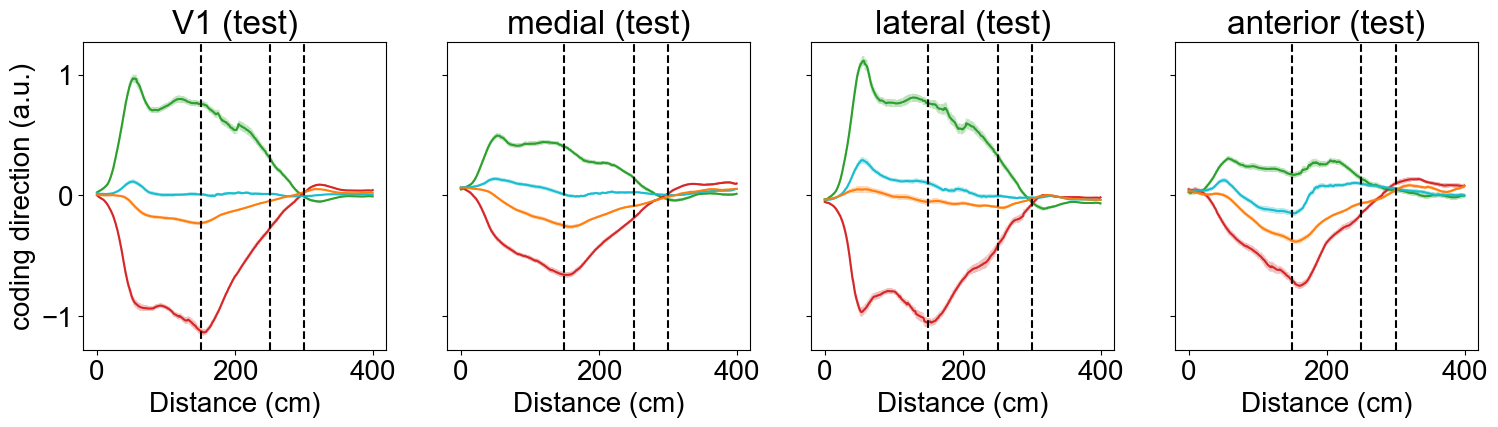

In [418]:
from scipy.stats import sem
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
        else:
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('coding direction (a.u.)')

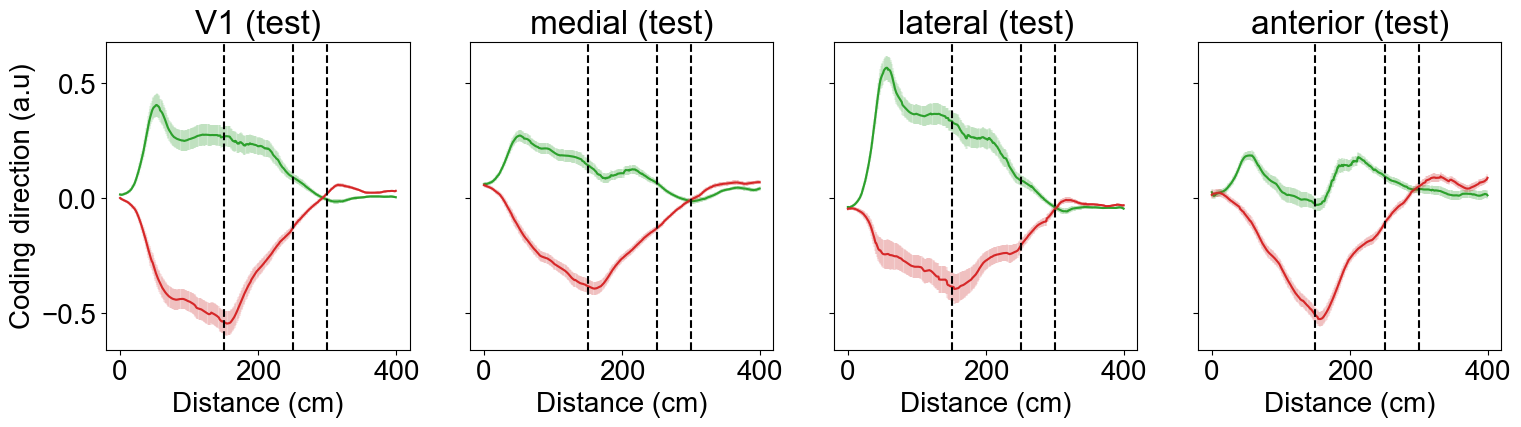

In [419]:
all_rew = np.concatenate([m1.trial_dict['rewarded'][1::2], m1.trial_dict['rewarded test']])
all_nrew = np.concatenate([m1.trial_dict['non rewarded'][1::2], m1.trial_dict['non rewarded test']])

all_dict = {
    "rewarded": all_rew,
    "non rewarded": all_nrew,
}
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(all_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')

# only using the first part of the corridor:

In [420]:
utils.compute_dprime(m1, discrimination_region = (30,150), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


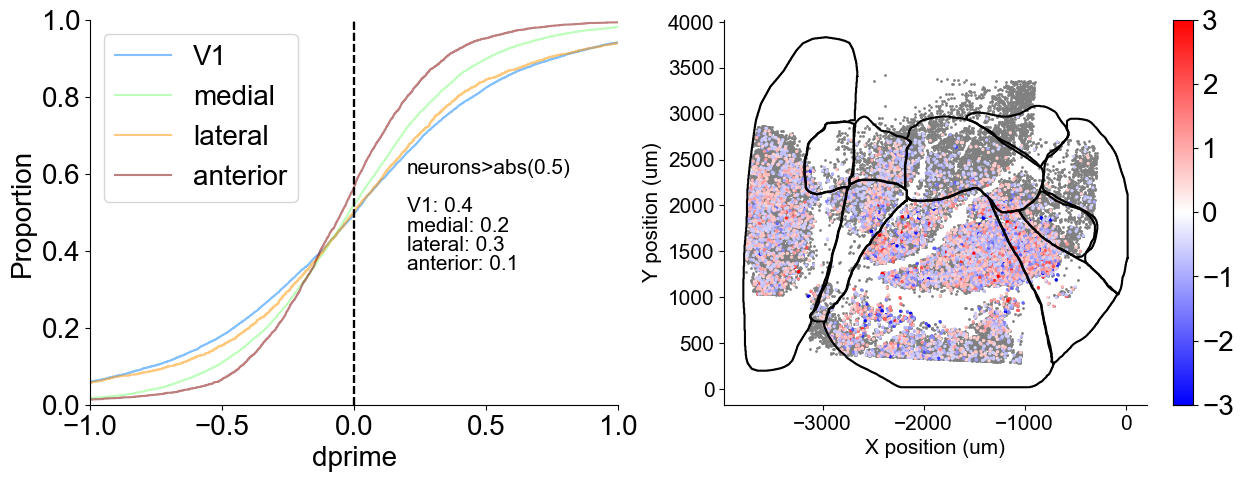

In [421]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 0.5
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],1)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-1,1)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

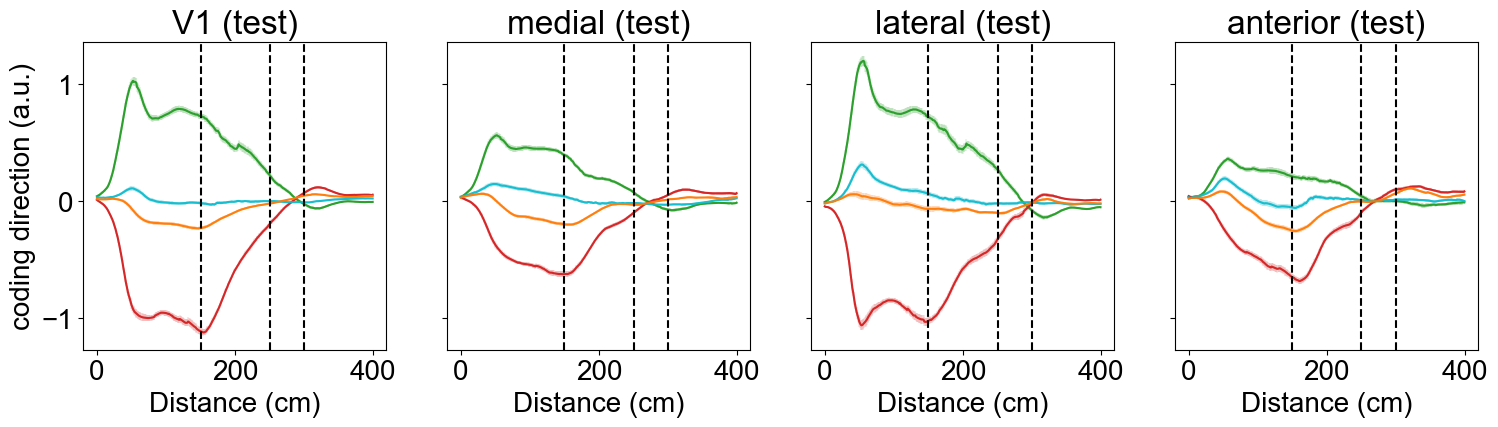

In [422]:
from scipy.stats import sem
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
        else:
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('coding direction (a.u.)')

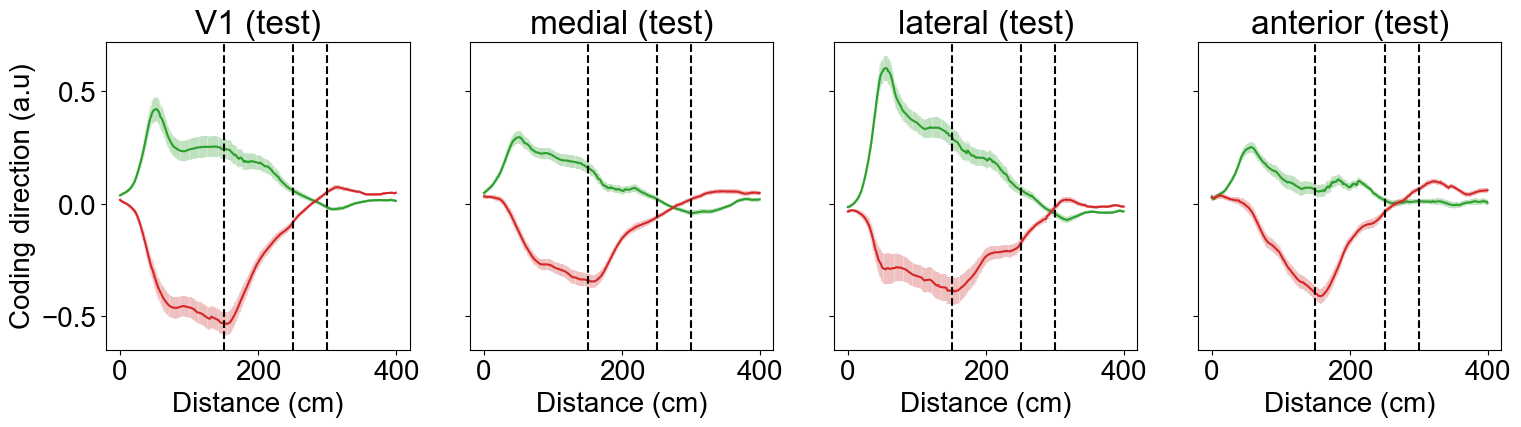

In [423]:
all_rew = np.concatenate([m1.trial_dict['rewarded'][1::2], m1.trial_dict['rewarded test']])
all_nrew = np.concatenate([m1.trial_dict['non rewarded'][1::2], m1.trial_dict['non rewarded test']])

all_dict = {
    "rewarded": all_rew,
    "non rewarded": all_nrew,
}
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(all_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')

# what if we use all the instances in the category to compute the dp?

In [424]:
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False, concatenate=True)

dprime saved in MouseObject.train_dp (neurons) using even trials


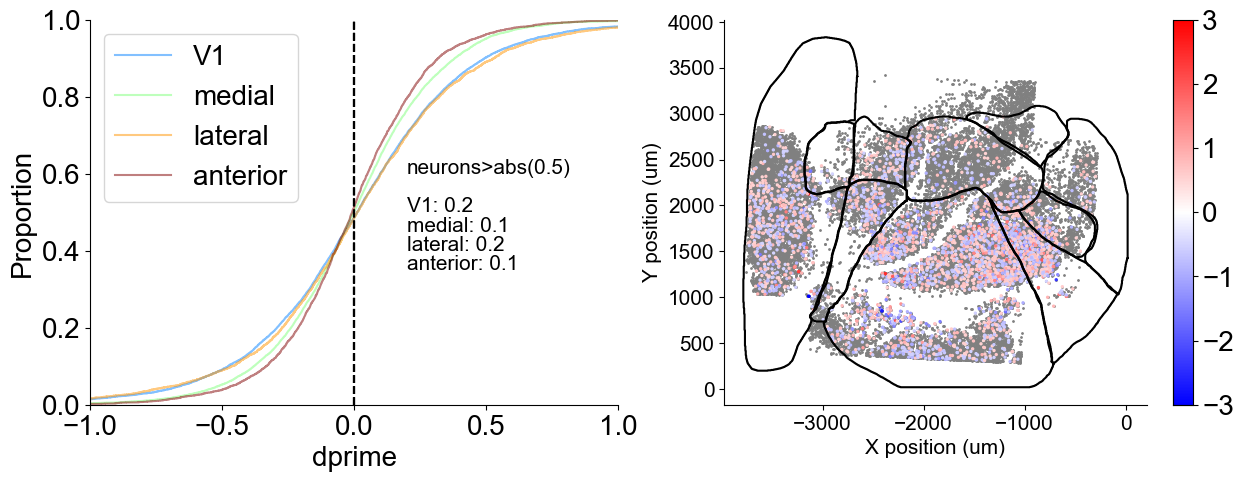

In [425]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 0.5
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],1)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-1,1)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

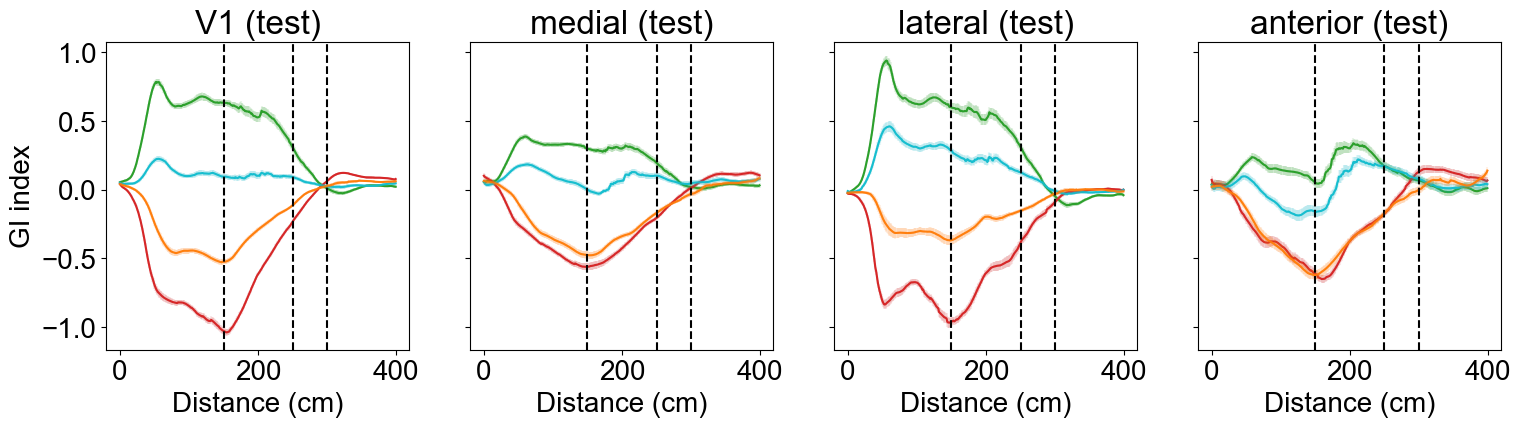

In [426]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    if indexa == 0:
        ax[indexa].set_ylabel('GI index')

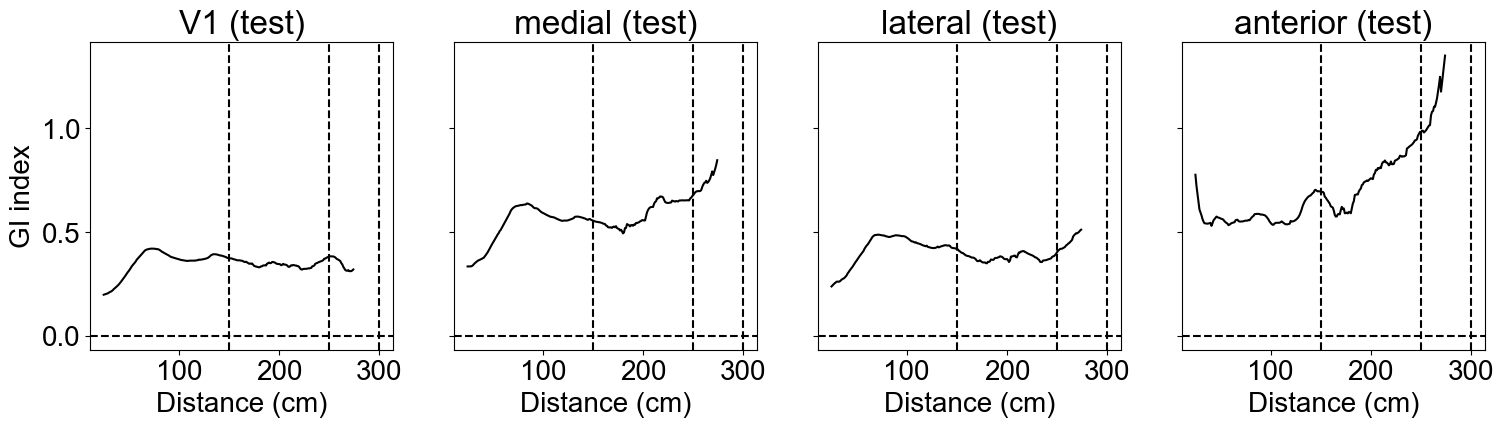

In [427]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((len(areas), 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            avg_resp[i_t] = avg_dir_plot.mean(0)
    gi_index = (avg_resp[2] - avg_resp[3]) / (avg_resp[0] - avg_resp[1]) 
    ax[indexa].plot(np.arange(25,275), gi_index[25:275], color = 'k', linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].axhline(y=0, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('GI index')

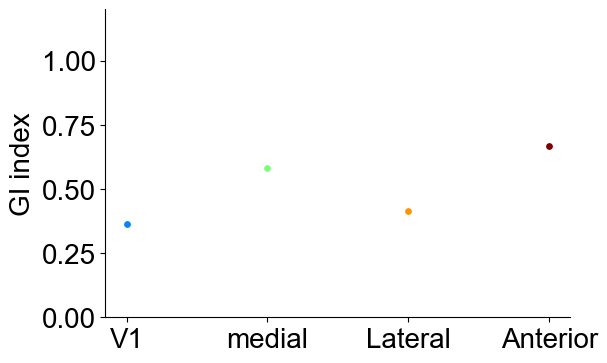

In [428]:
fig, ax = plt.subplots(1,1, figsize=(6,4), sharey=True)
avg_resp = np.empty((len(areas), 400))
gi_index_firstday = np.empty((len(areas), 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            avg_resp[i_t] = avg_dir_plot.mean(0)
    gi_index_firstday[indexa] = (avg_resp[2] - avg_resp[3]) / (avg_resp[0] - avg_resp[1]) 
    gi_a = gi_index_firstday[indexa,:]
    ax.errorbar(indexa, gi_a[50:250].mean(), sem(gi_a[50:250]), color = area_dict[area])
    ax.scatter(indexa, gi_a[50:250].mean(), color = area_dict[area],s=15)
    ax.set_xticks([0,1,2,3],["V1","medial", "Lateral", "Anterior"])
    ax.set_ylim(0,1.2)
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax.set_ylabel('GI index')
sns.despine()

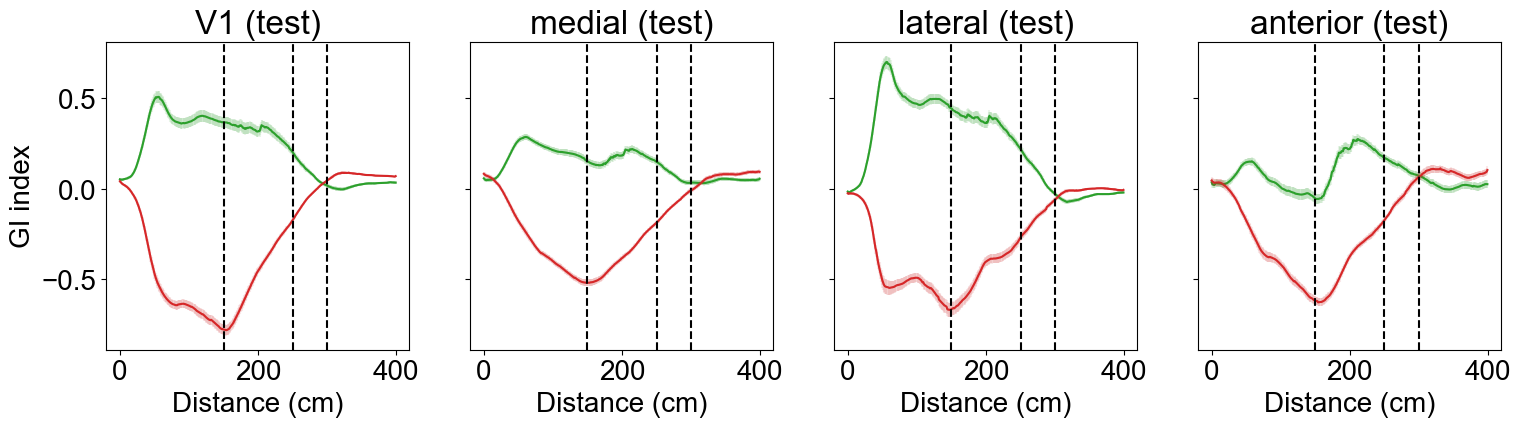

In [274]:
all_rew_test = np.concatenate([m1.trial_dict['rewarded'][1::2], m1.trial_dict['rewarded test'][1::2]])
all_nrew_test = np.concatenate([m1.trial_dict['non rewarded'][1::2], m1.trial_dict['non rewarded test'][1::2]])

all_dict = {
    "rewarded": all_rew_test,
    "non rewarded": all_nrew_test,
}
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(all_dict.items()): 
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('GI index')

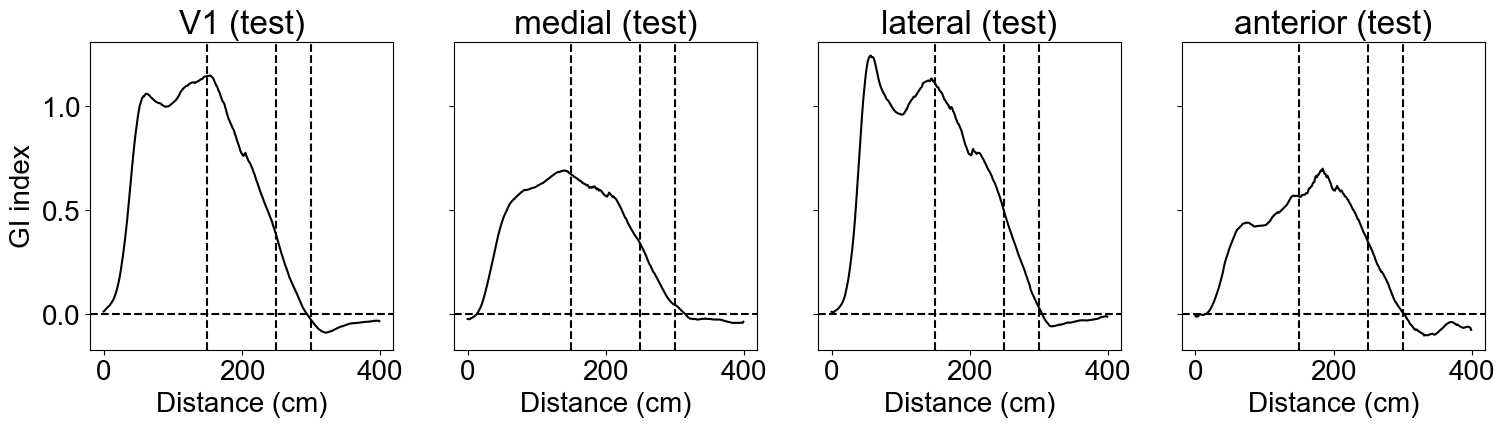

In [275]:
all_rew_test = np.concatenate([m1.trial_dict['rewarded'][1::2], m1.trial_dict['rewarded test'][1::2]])
all_nrew_test = np.concatenate([m1.trial_dict['non rewarded'][1::2], m1.trial_dict['non rewarded test'][1::2]])

all_dict = {
    "rewarded": all_rew_test,
    "non rewarded": all_nrew_test,
}
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    resp_to_rew = avg_dir[all_rew_test].mean(0)
    resp_to_nrew = avg_dir[all_nrew_test].mean(0)
    gi_index = (resp_to_rew - resp_to_nrew)
    ax[indexa].plot(np.arange(0,400),gi_index, color = 'k', linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].axhline(y=0, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('GI index')

# optimal behavior day

In [276]:
m1 = utils.load_mouse('VG11','2024_10_31', '2', load_neurons=True, interp_behav=True, load_retinotopy=True)
frameselector = utils.get_frameselector(m1)
istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m1.frameselector = (frameselector.reset_index()
      .rename(columns = {'index':'frame'})
      .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
      .set_index('frame'))
m1._spks = m1._spks[m1._snr>=.25]
m1._xpos = m1._xpos[m1._snr>=.25]
m1._ypos = m1._ypos[m1._snr>=.25]
m1._iplane = m1._iplane[m1._snr>=.25]
m1.iarea = m1.iarea[m1._snr>=.25]
m1.iregion = m1.iregion[m1._snr>=.25]
m1.xy_t = m1.xy_t[m1._snr>=.25]
m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = True, corridor_length=400)

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_10_31\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_10_31_2.mat not found, trying with fname: VG11_2024_10_31_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [06:38<00:00, 19.92s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_10_31_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
39 13396
interpolating 29842 neurons, 13358 frames to
the vector of distance with shape: (13358,)
neurons: 29842, trials: 254, corridor length: 400


In [353]:
m1.trial_dict = utils.get_trialno_bytype(m1.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


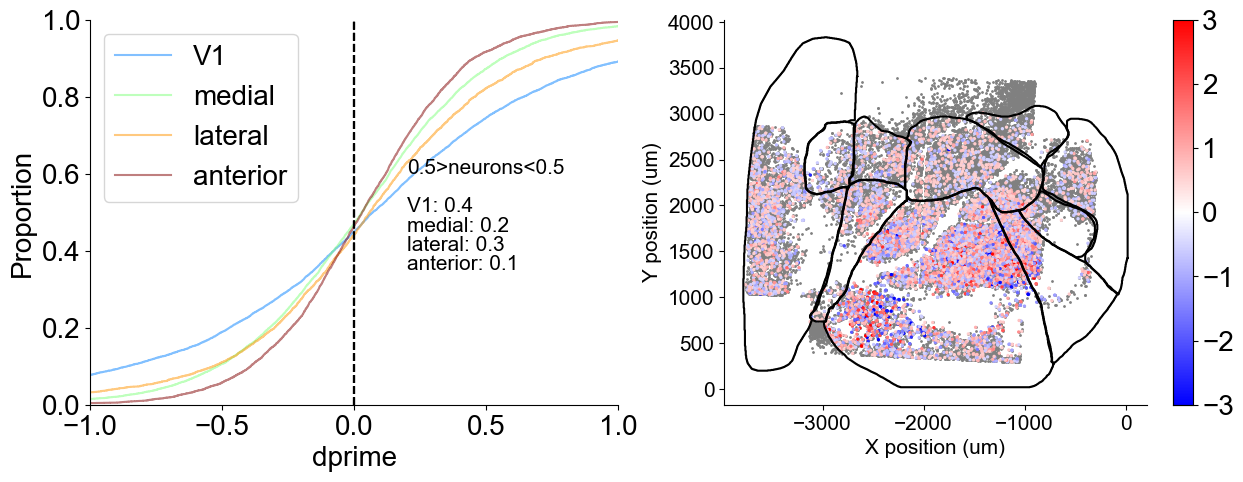

In [ ]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 0.5
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],1)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-1,1)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

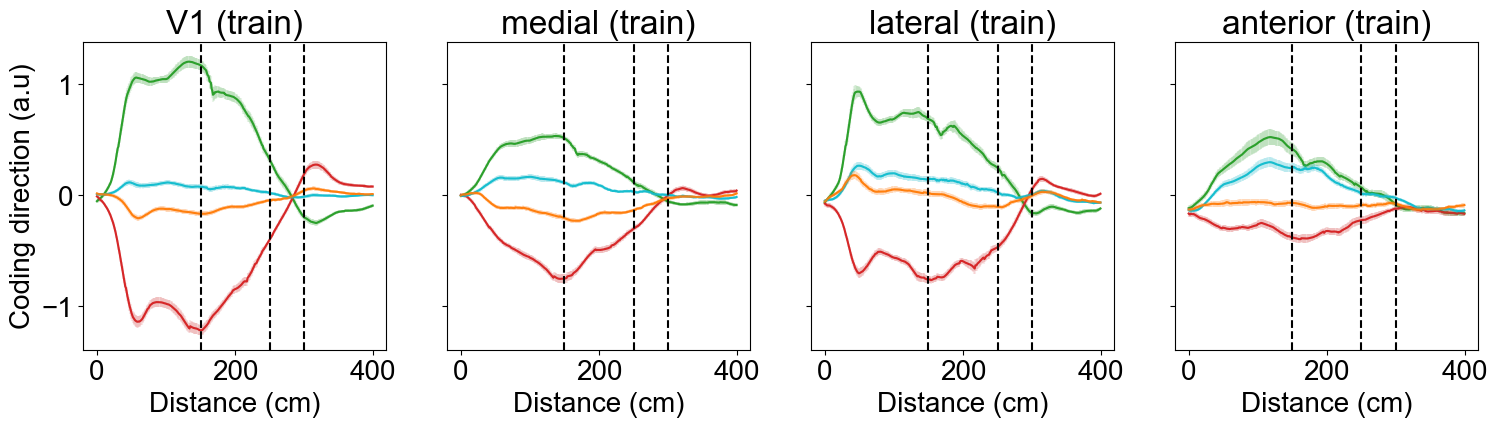

In [355]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
        else:
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (train)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')    

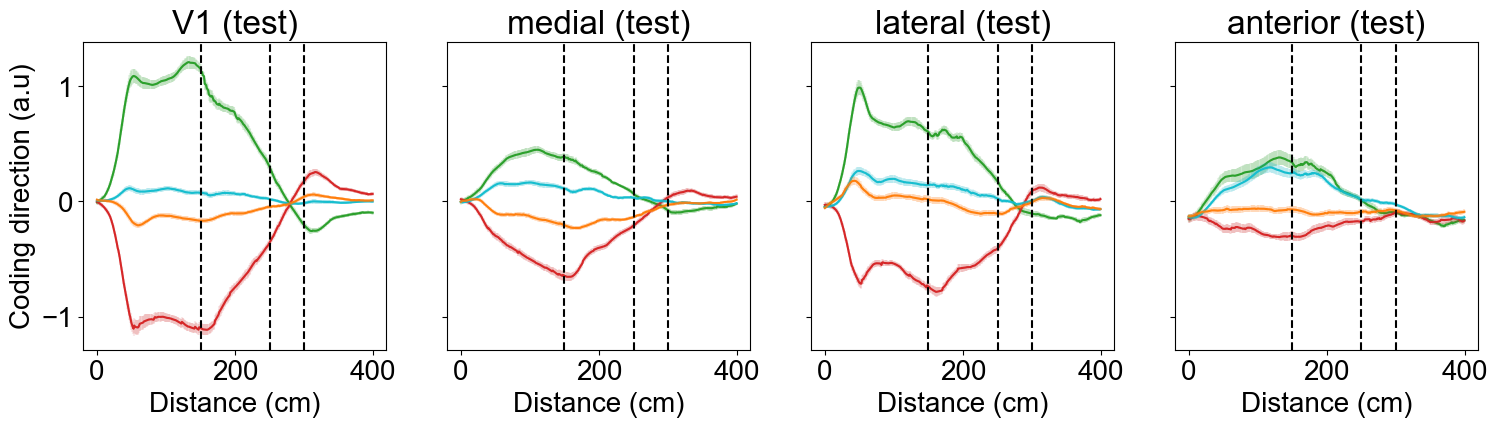

In [356]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
        else:
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')

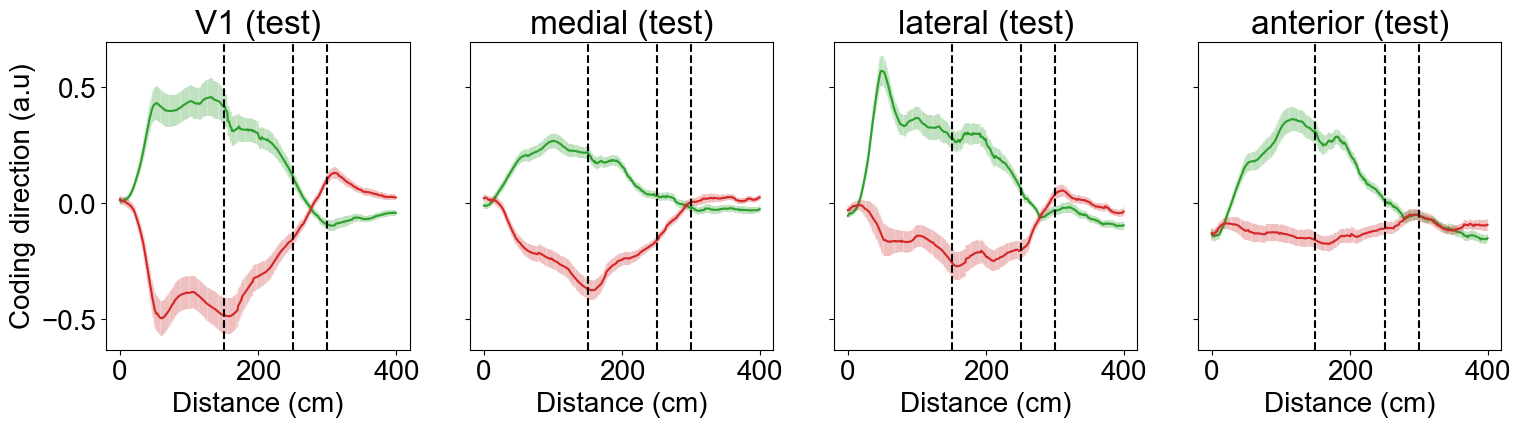

In [357]:
all_rew = np.concatenate([m1.trial_dict['rewarded'][1::2], m1.trial_dict['rewarded test']])
all_nrew = np.concatenate([m1.trial_dict['non rewarded'][1::2], m1.trial_dict['non rewarded test']])

all_dict = {
    "rewarded": all_rew,
    "non rewarded": all_nrew,
}
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(all_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')

# lick contribution 

In [358]:
trials_licks = {}
trials_nolicks = {}
for k in m1.trial_dict.keys():
    t_licks, t_no_licks = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype=k)
    trials_licks[k] = t_licks
    trials_nolicks[k] = t_no_licks

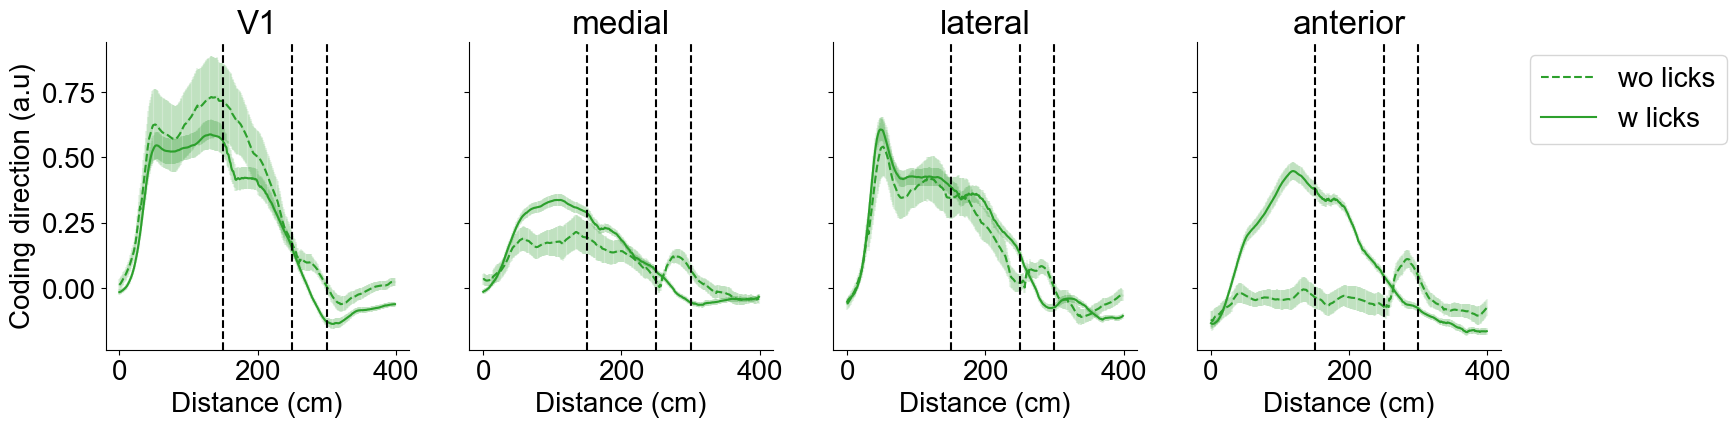

In [359]:
rtrials_nolick  = np.concatenate([trials_nolicks['rewarded'], trials_nolicks['rewarded test']])
rtrials_wlick  = np.concatenate([trials_licks['rewarded'], trials_licks['rewarded test']])


fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    avg_dir_plot = avg_dir[rtrials_nolick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
    avg_dir_plot = avg_dir[rtrials_wlick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, label='w licks')
    ax[indexa].set_title(f"{area}")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

Text(0, 0.5, 'Rewarded trials wo licks')

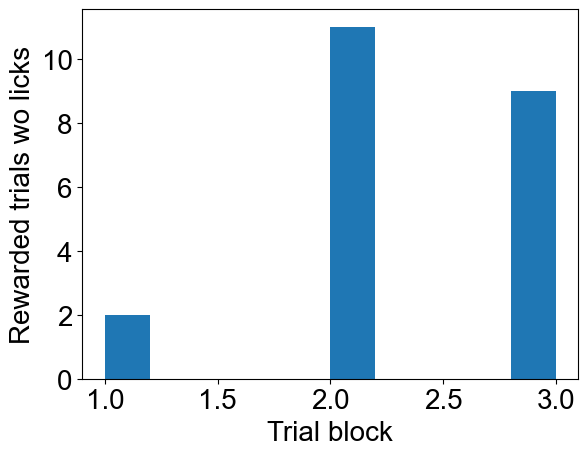

In [360]:
sorted_r_wlick = np.sort((rtrials_nolick))
plt.hist(pd.cut(sorted_r_wlick, bins=[0,75,150,225,300], labels=False));
plt.xlabel('Trial block')
plt.ylabel('Rewarded trials wo licks')

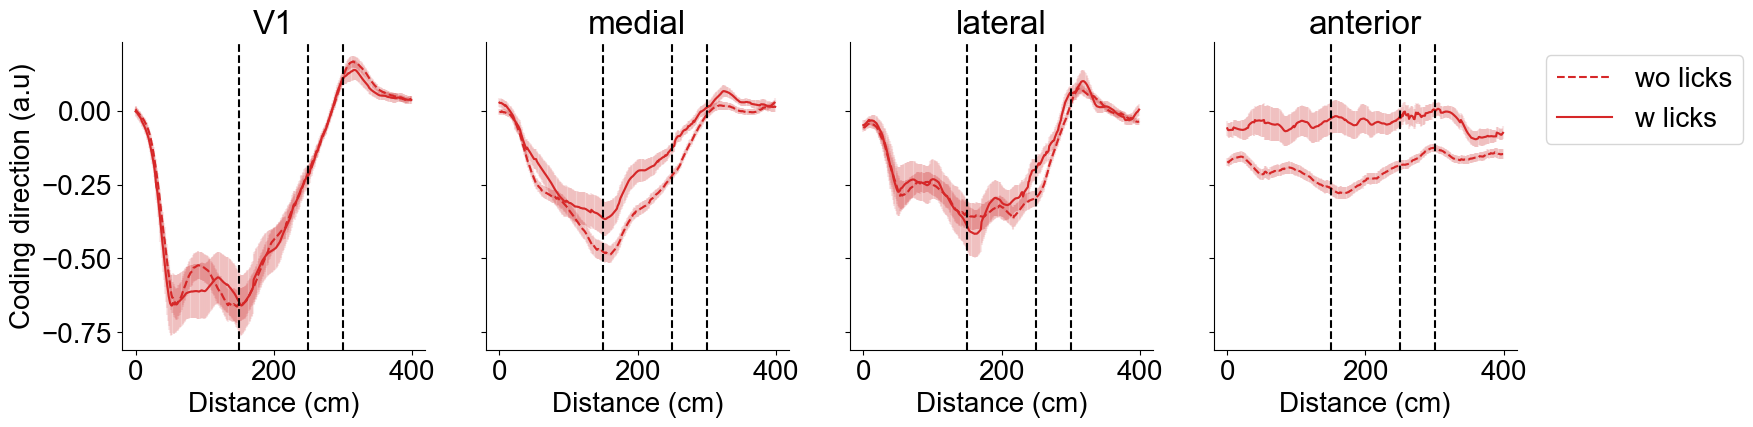

In [361]:
nrtrials_nolick  = np.concatenate([trials_nolicks['non rewarded'], trials_nolicks['non rewarded test']])
nrtrials_wlick  = np.concatenate([trials_licks['non rewarded'], trials_licks['non rewarded test']])
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    avg_dir_plot = avg_dir[nrtrials_nolick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
    avg_dir_plot = avg_dir[nrtrials_wlick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, label='w licks')
    ax[indexa].set_title(f"{area}")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

Text(0, 0.5, 'Rewarded trials wo licks')

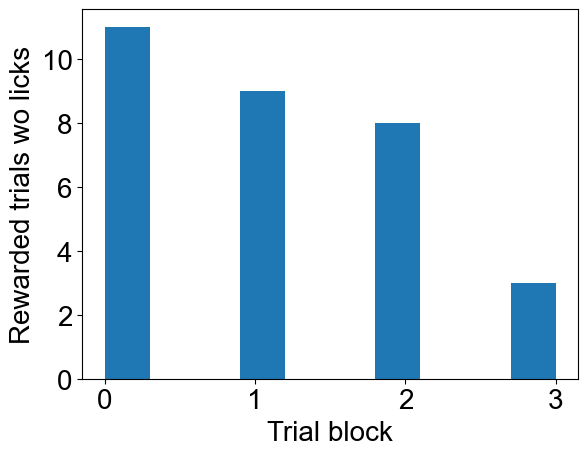

In [362]:
sorted_nr_wlick = np.sort((nrtrials_wlick))
plt.hist(pd.cut(sorted_nr_wlick, bins=[0,75,150,225,300], labels=False));
plt.xlabel('Trial block')
plt.ylabel('Rewarded trials wo licks')

# using only the first half of the corridor

In [363]:
m1.trial_dict = utils.get_trialno_bytype(m1.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
utils.compute_dprime(m1, discrimination_region = (25,150), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


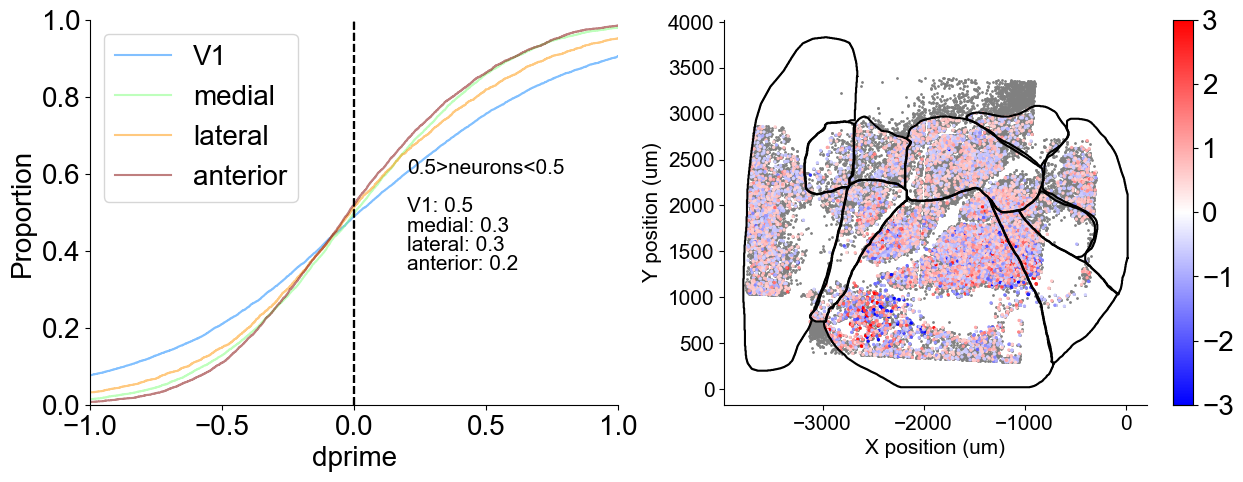

In [ ]:
rea_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 0.5
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],1)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-1,1)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

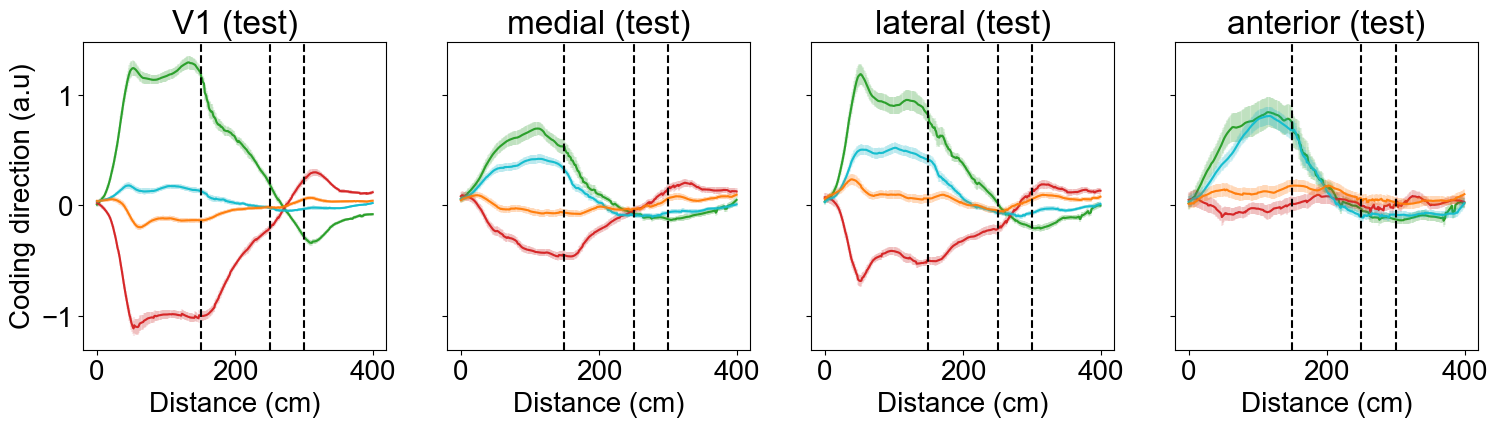

In [365]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
        else:
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')

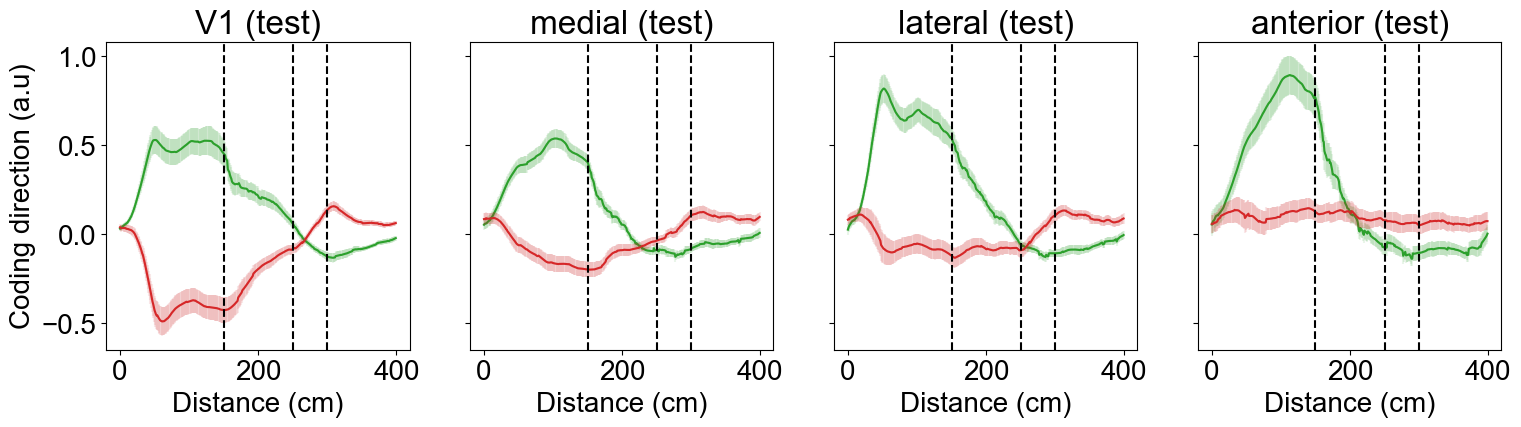

In [366]:
all_rew = np.concatenate([m1.trial_dict['rewarded'][1::2], m1.trial_dict['rewarded test']])
all_nrew = np.concatenate([m1.trial_dict['non rewarded'][1::2], m1.trial_dict['non rewarded test']])

all_dict = {
    "rewarded": all_rew,
    "non rewarded": all_nrew,
}
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(all_dict.items()): 
        if ttype in ['rewarded', 'non rewarded']:    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')

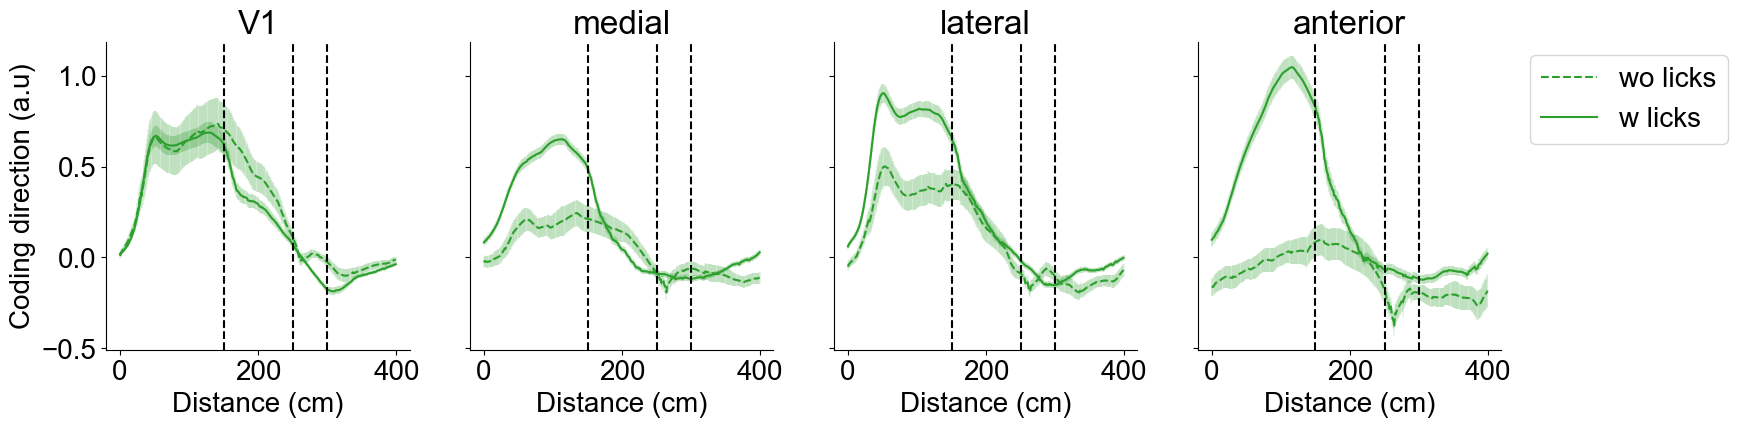

In [367]:
rtrials_nolick  = np.concatenate([trials_nolicks['rewarded'], trials_nolicks['rewarded test']])
rtrials_wlick  = np.concatenate([trials_licks['rewarded'], trials_licks['rewarded test']])


fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    avg_dir_plot = avg_dir[rtrials_nolick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
    avg_dir_plot = avg_dir[rtrials_wlick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, label='w licks')
    ax[indexa].set_title(f"{area}")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

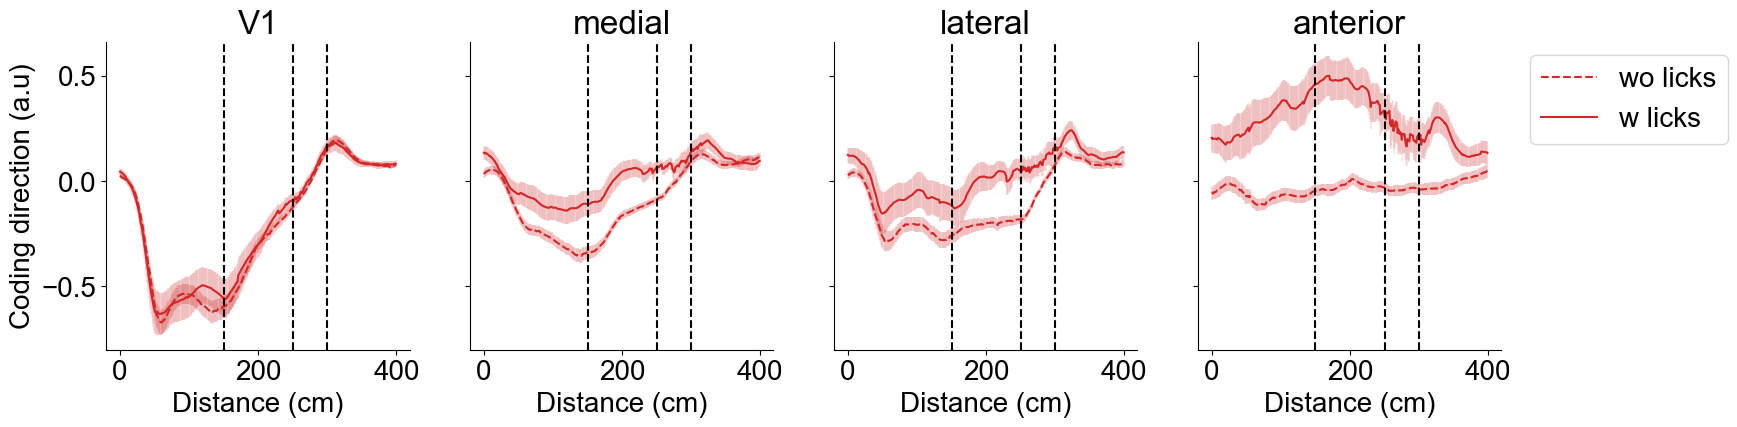

In [368]:
nrtrials_nolick  = np.concatenate([trials_nolicks['non rewarded'], trials_nolicks['non rewarded test']])
nrtrials_wlick  = np.concatenate([trials_licks['non rewarded'], trials_licks['non rewarded test']])
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    avg_dir_plot = avg_dir[nrtrials_nolick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
    avg_dir_plot = avg_dir[nrtrials_wlick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, label='w licks')
    ax[indexa].set_title(f"{area}")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

# concatenate all the instances in the category

# all the corridor

In [369]:
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False, concatenate=True)

dprime saved in MouseObject.train_dp (neurons) using even trials


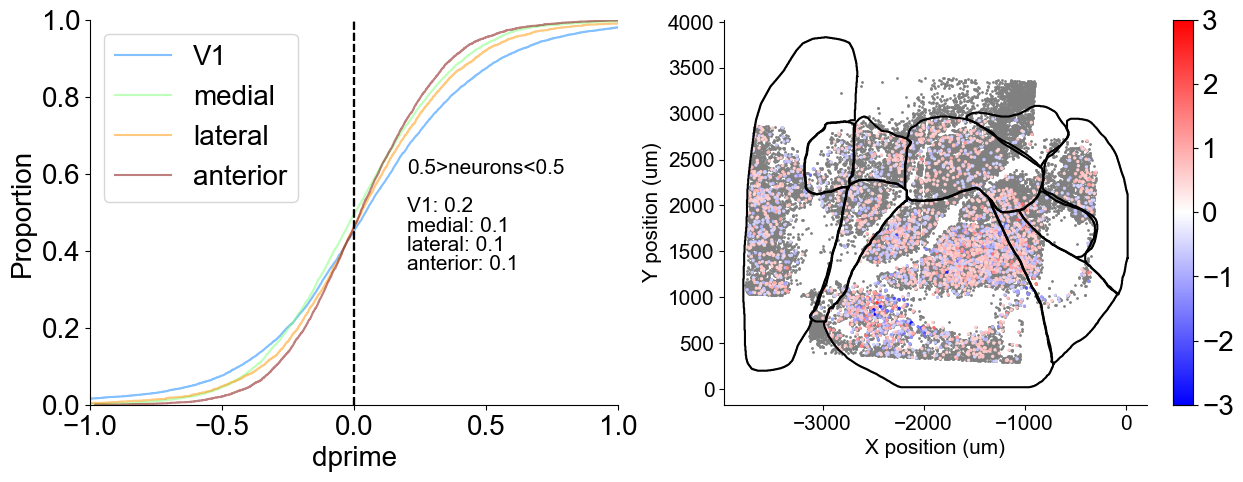

In [ ]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 0.5
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],1)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-1,1)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

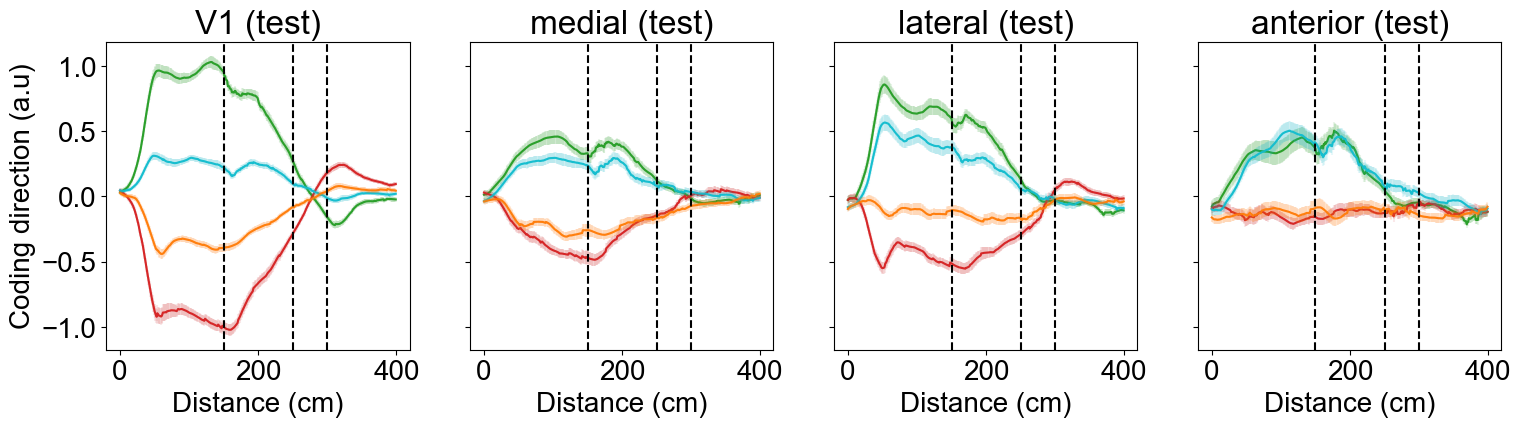

In [371]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')

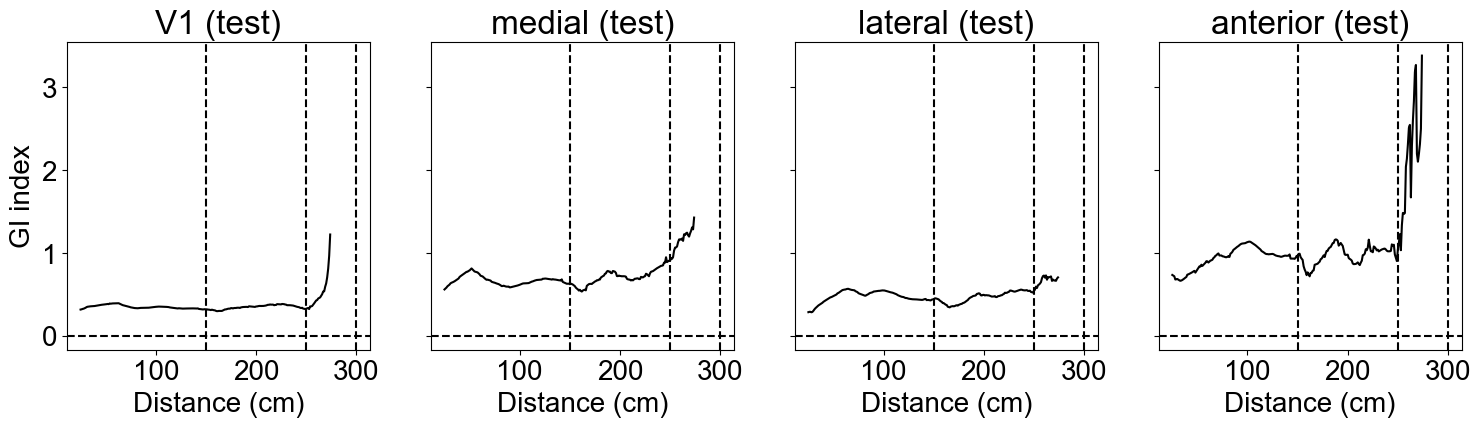

In [372]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((len(areas), 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            avg_resp[i_t] = avg_dir_plot.mean(0)
    gi_index = (avg_resp[2] - avg_resp[3]) / (avg_resp[0] - avg_resp[1]) 
    ax[indexa].plot(np.arange(25,275), gi_index[25:275], color = 'k', linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].axhline(y=0, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('GI index')

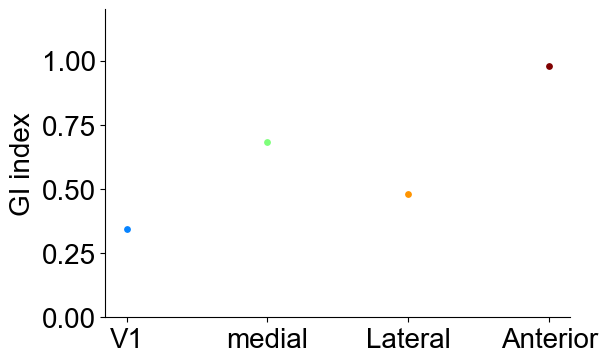

In [374]:
fig, ax = plt.subplots(1,1, figsize=(6,4), sharey=True)
avg_resp = np.empty((len(areas), 400))
gi_index_optimal = np.empty((len(areas), 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            avg_resp[i_t] = avg_dir_plot.mean(0)
    gi_index_optimal[indexa] = (avg_resp[2] - avg_resp[3]) / (avg_resp[0] - avg_resp[1]) 
    gi_a = gi_index_optimal[indexa,:]
    ax.errorbar(indexa, gi_a[50:250].mean(), sem(gi_a[50:250]), color = area_dict[area])
    ax.scatter(indexa, gi_a[50:250].mean(), color = area_dict[area],s=15)
    ax.set_xticks([0,1,2,3],["V1","medial", "Lateral", "Anterior"])
    ax.set_ylim(0,1.2)
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax.set_ylabel('GI index')
sns.despine()

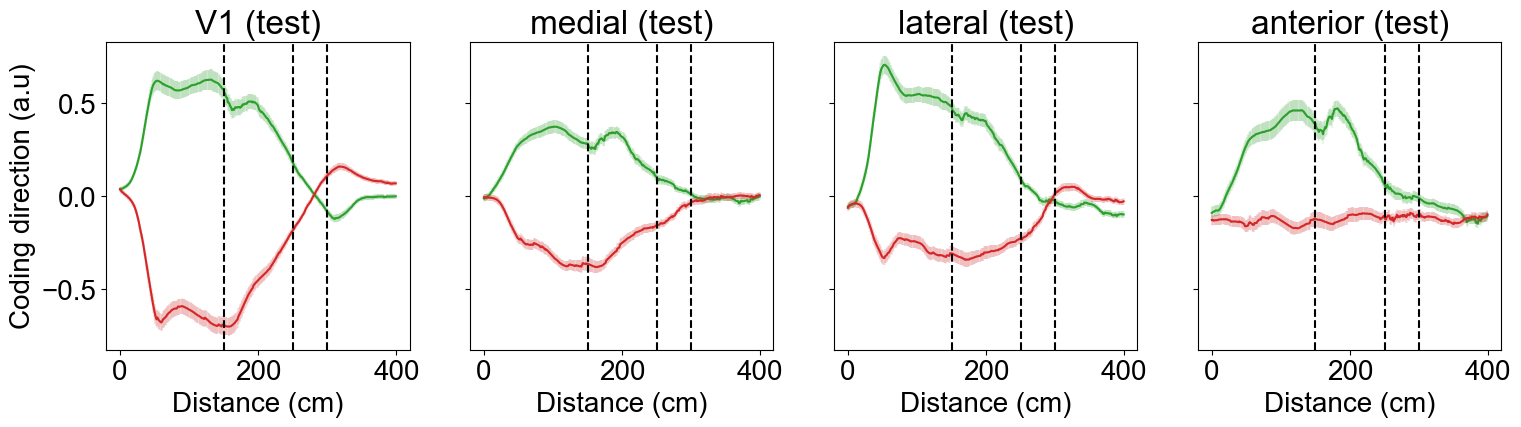

In [375]:
all_rew_test = np.concatenate([m1.trial_dict['rewarded'][1::2], m1.trial_dict['rewarded test'][1::2]])
all_nrew_test = np.concatenate([m1.trial_dict['non rewarded'][1::2], m1.trial_dict['non rewarded test'][1::2]])

all_dict = {
    "rewarded": all_rew_test,
    "non rewarded": all_nrew_test,
}
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(all_dict.items()): 
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')

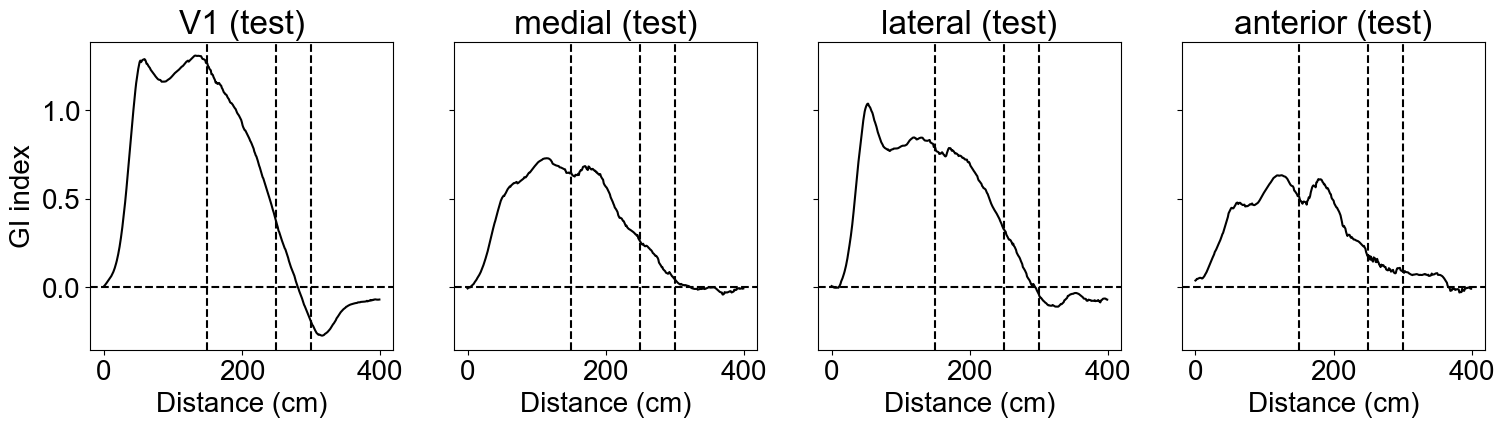

In [376]:
all_rew_test = np.concatenate([m1.trial_dict['rewarded'][1::2], m1.trial_dict['rewarded test'][1::2]])
all_nrew_test = np.concatenate([m1.trial_dict['non rewarded'][1::2], m1.trial_dict['non rewarded test'][1::2]])

all_dict = {
    "rewarded": all_rew_test,
    "non rewarded": all_nrew_test,
}
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    resp_to_rew = avg_dir[all_rew_test].mean(0)
    resp_to_nrew = avg_dir[all_nrew_test].mean(0)
    gi_index = (resp_to_rew - resp_to_nrew)
    ax[indexa].plot(np.arange(0,400),gi_index, color = 'k', linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].axhline(y=0, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('GI index')

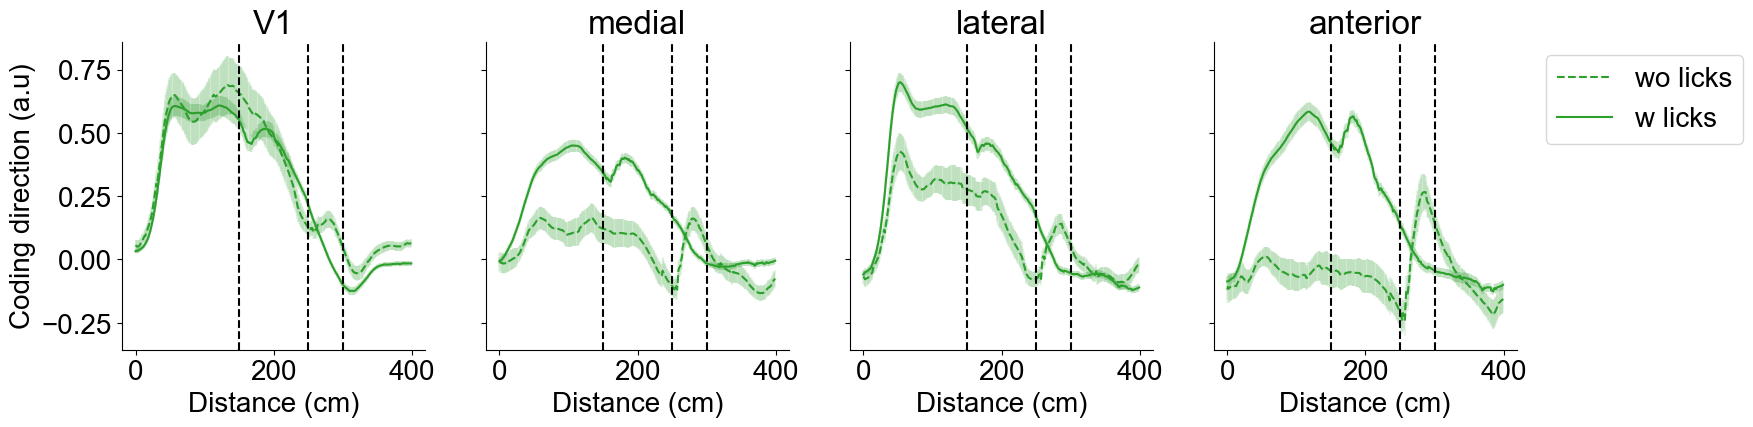

In [377]:
rtrials_nolick  = np.concatenate([trials_nolicks['rewarded'], trials_nolicks['rewarded test']])
rtrials_wlick  = np.concatenate([trials_licks['rewarded'], trials_licks['rewarded test']])


fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    avg_dir_plot = avg_dir[rtrials_nolick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
    avg_dir_plot = avg_dir[rtrials_wlick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, label='w licks')
    ax[indexa].set_title(f"{area}")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

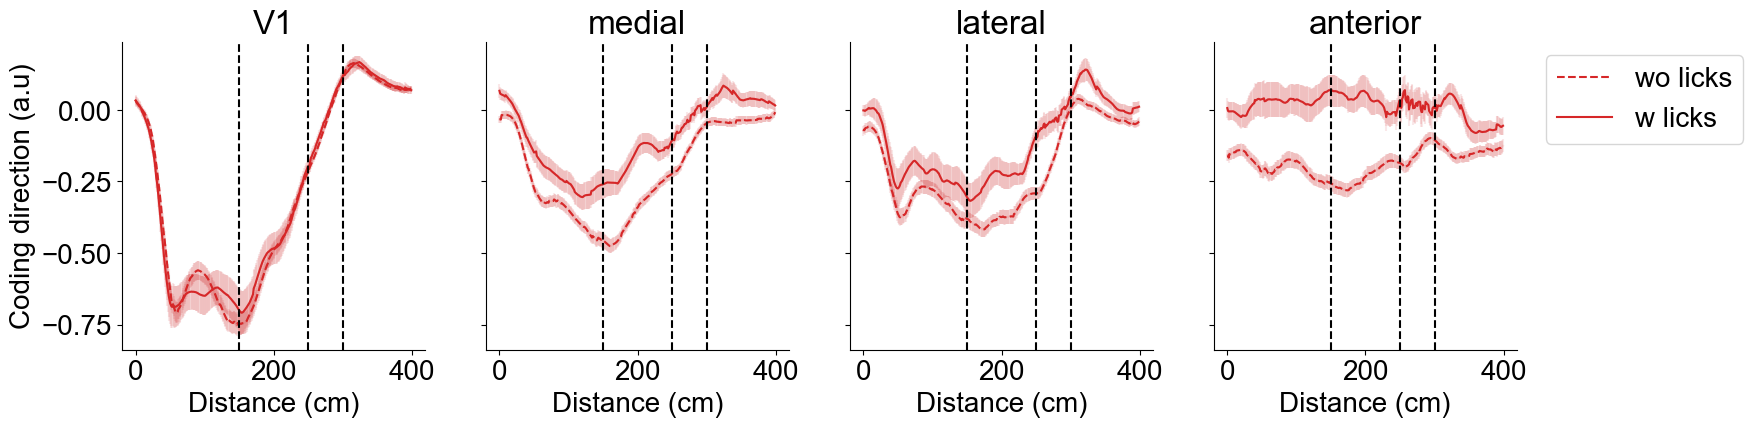

In [378]:
nrtrials_nolick  = np.concatenate([trials_nolicks['non rewarded'], trials_nolicks['non rewarded test']])
nrtrials_wlick  = np.concatenate([trials_licks['non rewarded'], trials_licks['non rewarded test']])
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    avg_dir_plot = avg_dir[nrtrials_nolick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
    avg_dir_plot = avg_dir[nrtrials_wlick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, label='w licks')
    ax[indexa].set_title(f"{area}")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

In [379]:
utils.compute_dprime(m1, discrimination_region = (25,150), corridor_length = 400, nogray = False, concatenate=True)

dprime saved in MouseObject.train_dp (neurons) using even trials


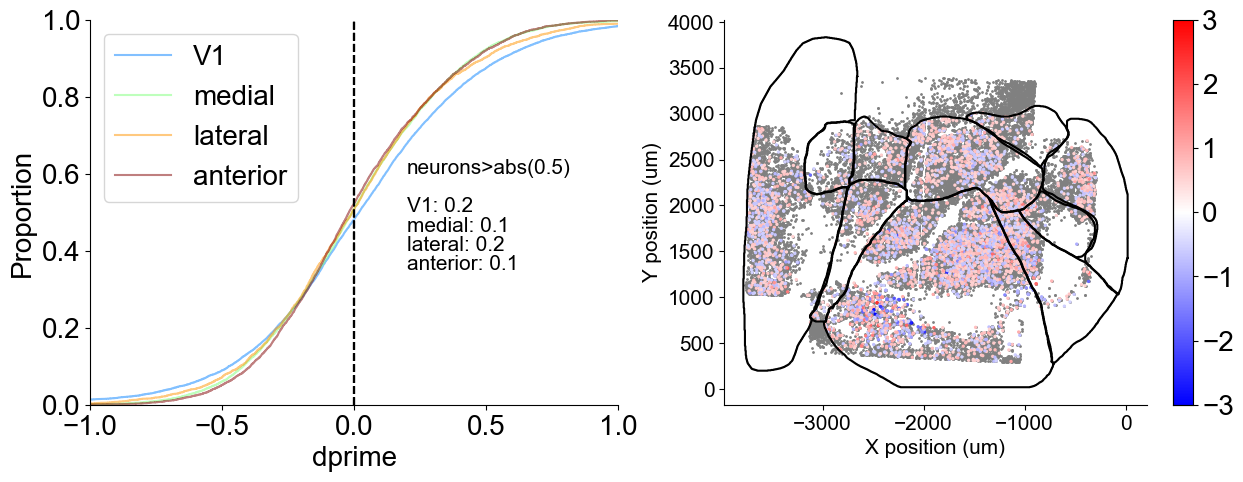

In [381]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 0.5
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],1)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-1,1)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

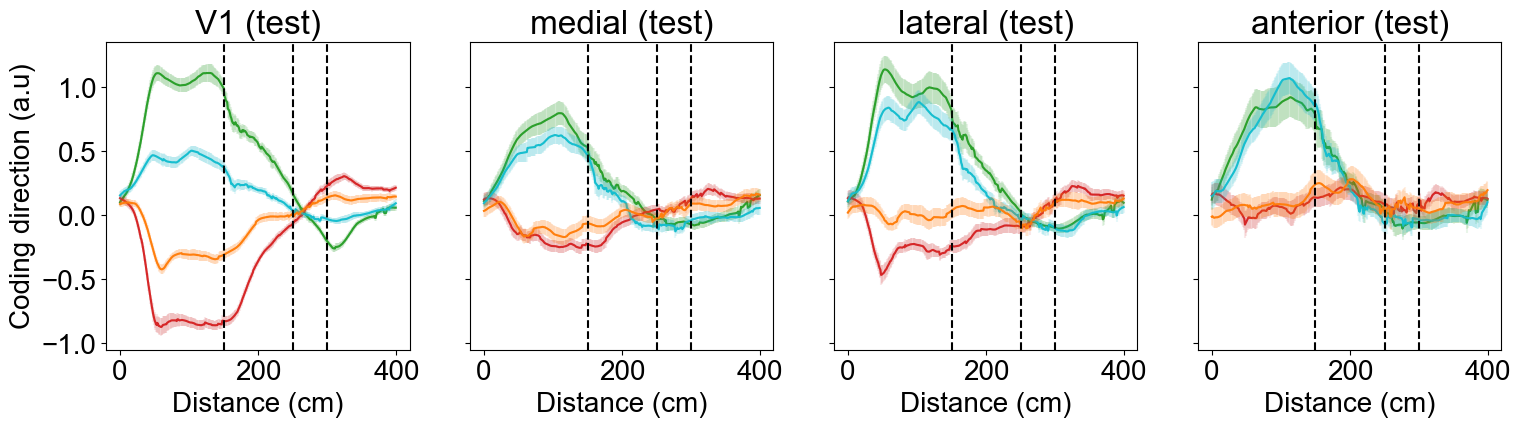

In [382]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')

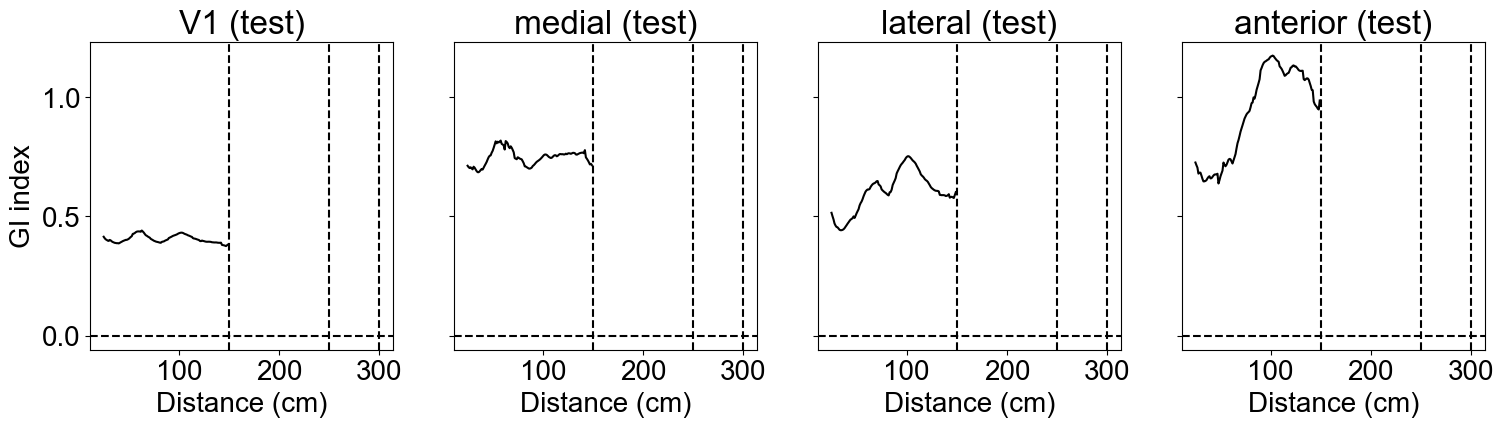

In [383]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((len(areas), 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            avg_resp[i_t] = avg_dir_plot.mean(0)
    gi_index = (avg_resp[2] - avg_resp[3]) / (avg_resp[0] - avg_resp[1]) 
    ax[indexa].plot(np.arange(25,150), gi_index[25:150], color = 'k', linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].axhline(y=0, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('GI index')

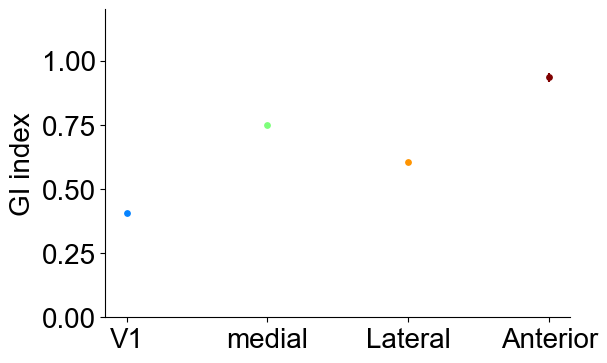

In [391]:
fig, ax = plt.subplots(1,1, figsize=(6,4), sharey=True)
avg_resp = np.empty((len(areas), 400))
gi_index_optimal_fh = np.empty((len(areas), 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            avg_resp[i_t] = avg_dir_plot.mean(0)
    gi_index_optimal_fh[indexa] = (avg_resp[2] - avg_resp[3]) / (avg_resp[0] - avg_resp[1]) 
    gi_a = gi_index_optimal_fh[indexa,:]
    ax.errorbar(indexa, gi_a[25:150].mean(), sem(gi_a[25:150]), color = area_dict[area])
    ax.scatter(indexa, gi_a[25:150].mean(), color = area_dict[area],s=15)
    ax.set_xticks([0,1,2,3],["V1","medial", "Lateral", "Anterior"])
    ax.set_ylim(0,1.2)
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax.set_ylabel('GI index')
sns.despine()

In [390]:
for a, area in enumerate(areas):
    print(f"{area} GI (25,275): {gi_index_optimal[a,25:250].mean()}, (25,150): {gi_index_optimal_fh[a,25:150].mean()}")

V1 GI (25,275): 0.3443427445655512, (25,150): 0.4053743476343315
medial GI (25,275): 0.6816089145838233, (25,150): 0.7477059912816194
lateral GI (25,275): 0.46868611042597447, (25,150): 0.6030423484001516
anterior GI (25,275): 0.9484996919346098, (25,150): 0.9344179766273463


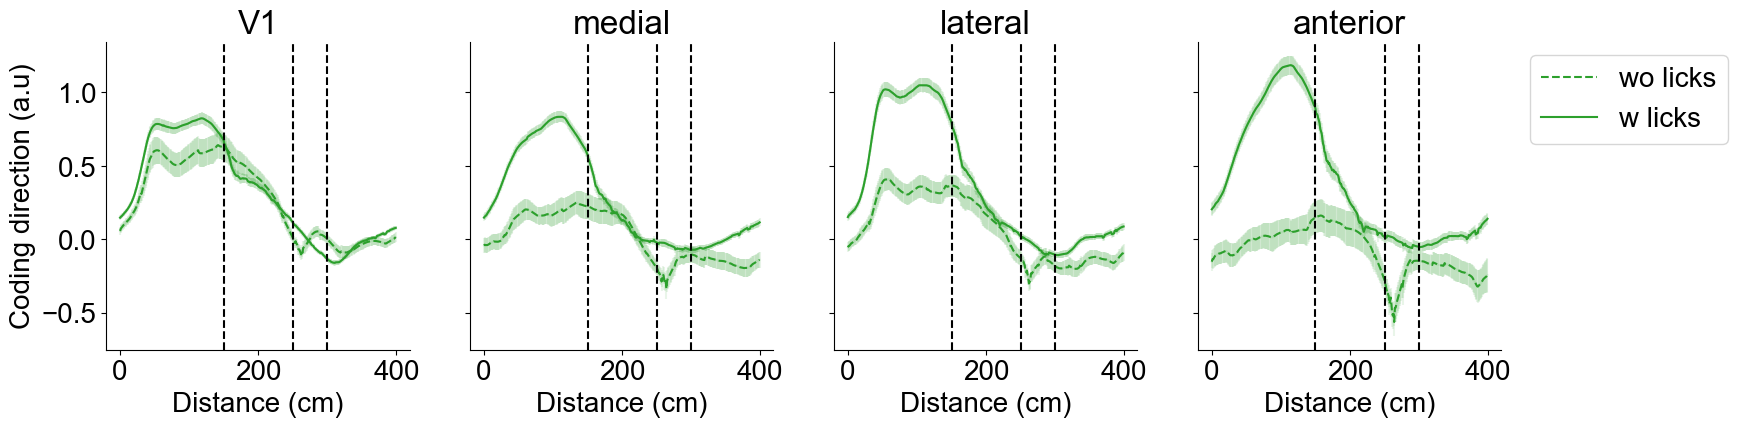

In [392]:
rtrials_nolick  = np.concatenate([trials_nolicks['rewarded'], trials_nolicks['rewarded test']])
rtrials_wlick  = np.concatenate([trials_licks['rewarded'], trials_licks['rewarded test']])


fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    avg_dir_plot = avg_dir[rtrials_nolick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
    avg_dir_plot = avg_dir[rtrials_wlick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, label='w licks')
    ax[indexa].set_title(f"{area}")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

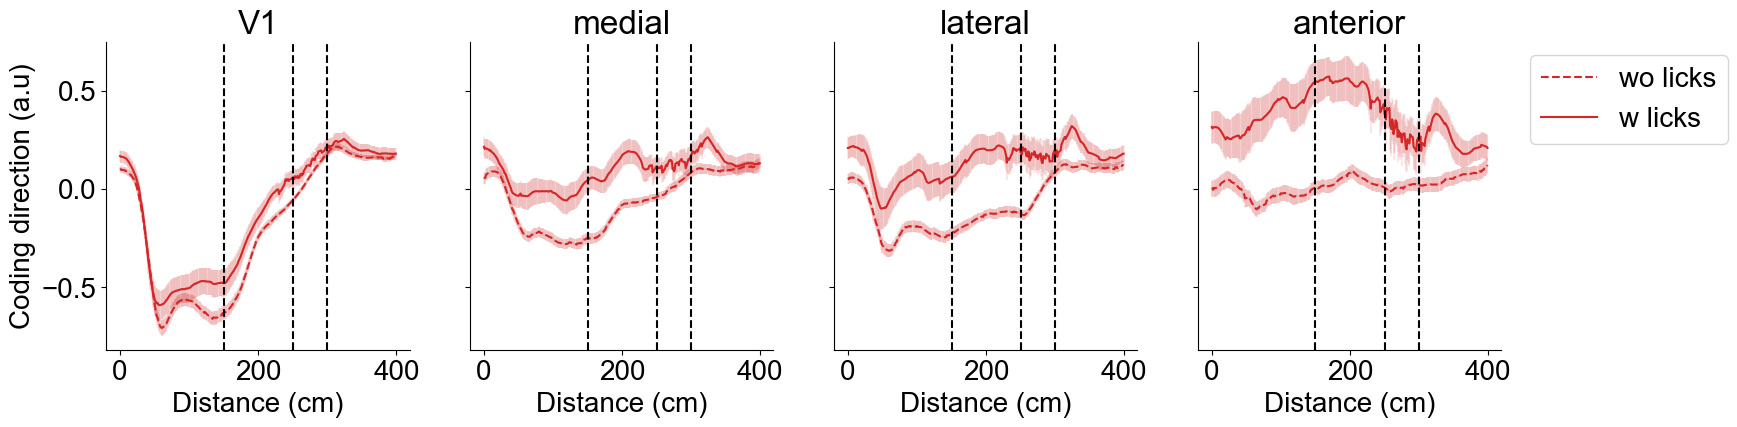

In [393]:
nrtrials_nolick  = np.concatenate([trials_nolicks['non rewarded'], trials_nolicks['non rewarded test']])
nrtrials_wlick  = np.concatenate([trials_licks['non rewarded'], trials_licks['non rewarded test']])
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    avg_dir_plot = avg_dir[nrtrials_nolick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
    avg_dir_plot = avg_dir[nrtrials_wlick]
    ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
    ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, label='w licks')
    ax[indexa].set_title(f"{area}")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

# last day all rew

In [441]:
m1 = utils.load_mouse('VG11','2024_11_01', '2', load_neurons=True, interp_behav=True, load_retinotopy=True)
frameselector = utils.get_frameselector(m1)
istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m1.frameselector = (frameselector.reset_index()
      .rename(columns = {'index':'frame'})
      .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
      .set_index('frame'))
m1._spks = m1._spks[m1._snr>=.25]
m1._xpos = m1._xpos[m1._snr>=.25]
m1._ypos = m1._ypos[m1._snr>=.25]
m1._iplane = m1._iplane[m1._snr>=.25]
m1.iarea = m1.iarea[m1._snr>=.25]
m1.iregion = m1.iregion[m1._snr>=.25]
m1.xy_t = m1.xy_t[m1._snr>=.25]
m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = True, corridor_length=400)

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG11\2024_11_01\2
Creating new mouse object ...
Timeline with fname: Timeline_VG11_2024_11_01_2.mat not found, trying with fname: VG11_2024_11_01_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [04:35<00:00, 13.76s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_11_01_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
40 10402
interpolating 19578 neurons, 10363 frames to
the vector of distance with shape: (10363,)
neurons: 19578, trials: 351, corridor length: 400


In [442]:
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False, concatenate=True)

dprime saved in MouseObject.train_dp (neurons) using even trials


In [445]:
m1.trial_dict = utils.get_trialno_bytype(m1.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}

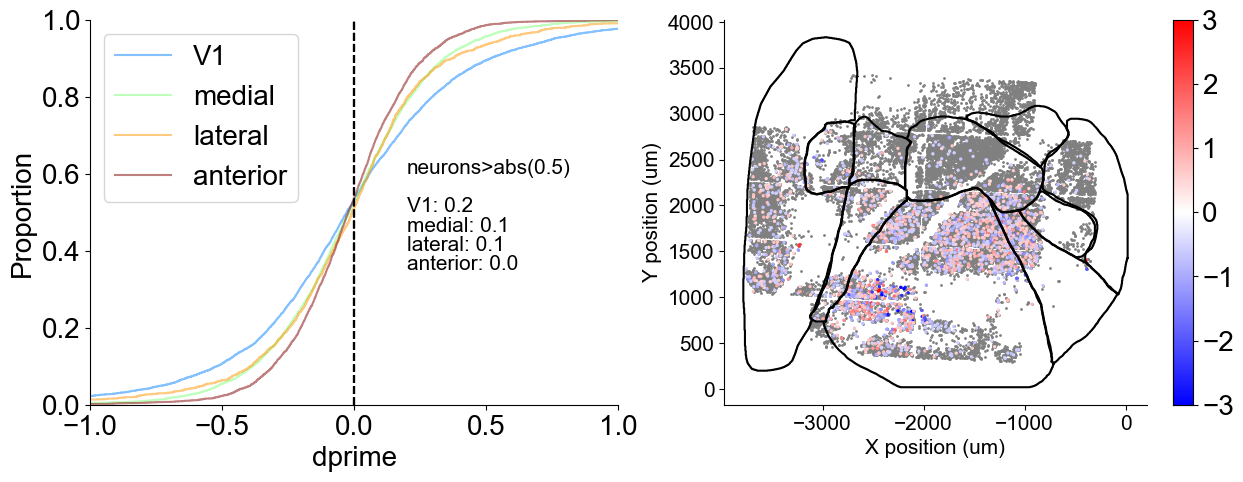

In [446]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 0.5
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],1)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-1,1)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

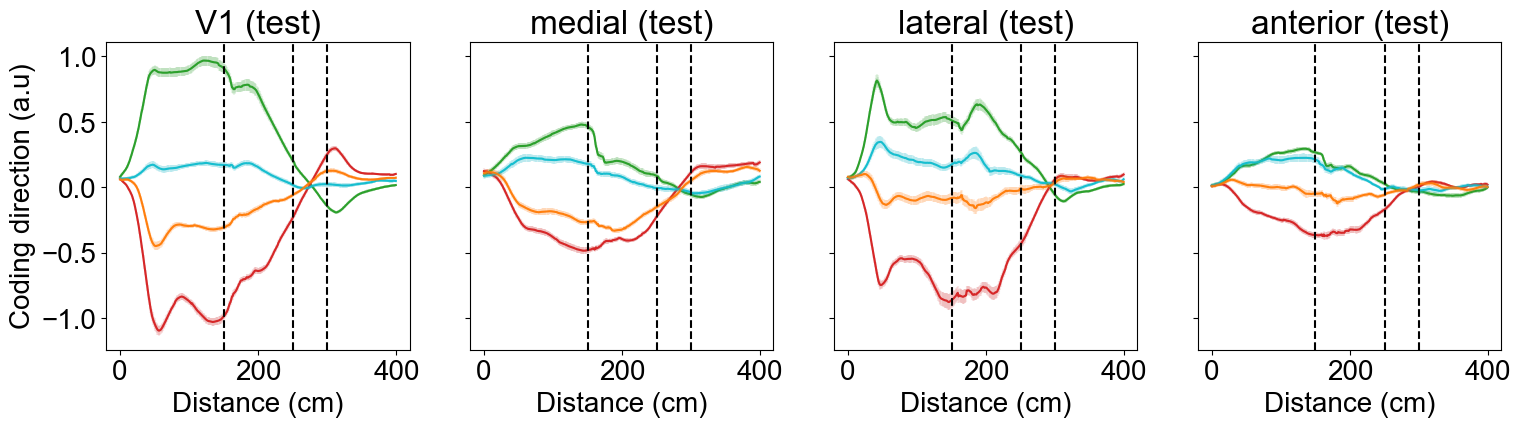

In [447]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            ax[indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
            ax[indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    if indexa == 0:
        ax[indexa].set_ylabel('Coding direction (a.u)')

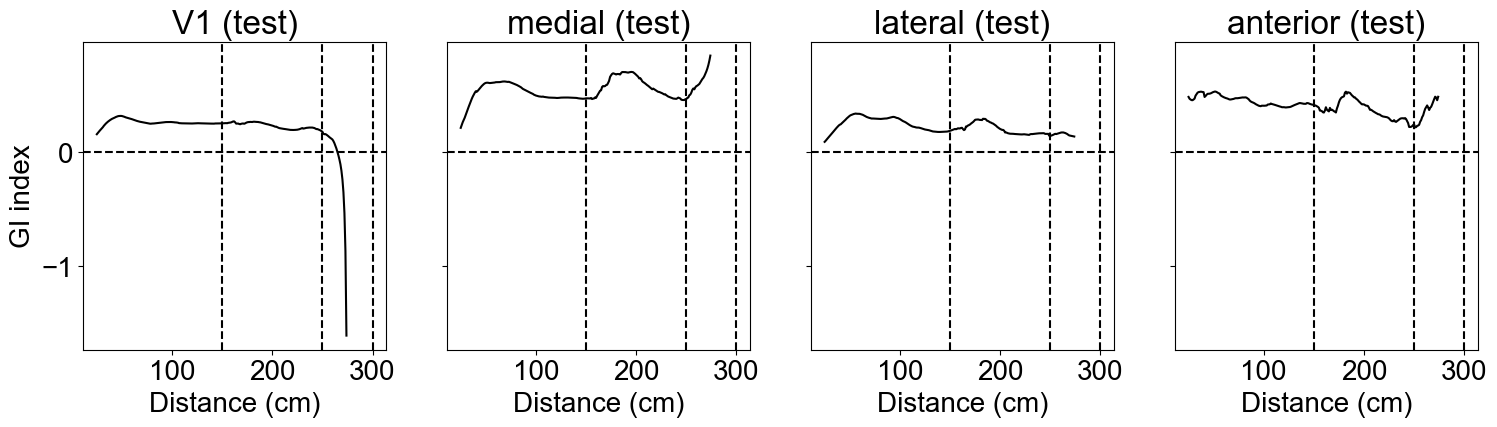

In [448]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((len(areas), 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            avg_resp[i_t] = avg_dir_plot.mean(0)
    gi_index = (avg_resp[2] - avg_resp[3]) / (avg_resp[0] - avg_resp[1]) 
    ax[indexa].plot(np.arange(25,275), gi_index[25:275], color = 'k', linewidth = 1.5)
    ax[indexa].set_title(f"{area} (test)")
    ax[indexa].axvline(x=150, color='k', linestyle='--')
    ax[indexa].axvline(x=250, color='k', linestyle='--')
    ax[indexa].axvline(x=300, color='k', linestyle='--')
    ax[indexa].axhline(y=0, color='k', linestyle='--')
    ax[indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax[indexa].set_ylabel('GI index')

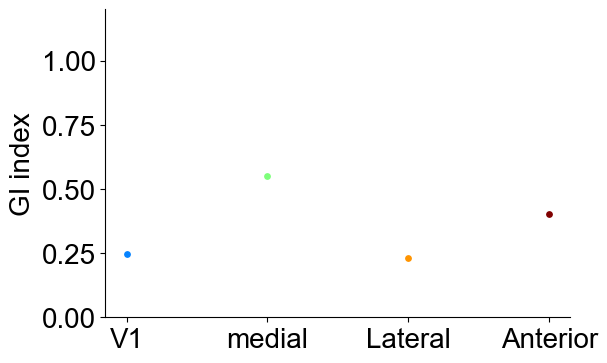

In [449]:
fig, ax = plt.subplots(1,1, figsize=(6,4), sharey=True)
avg_resp = np.empty((len(areas), 400))
gi_index_last = np.empty((len(areas), 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia], tsh=95) #tresh based on the area 
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia
    area_prefer_nr = prefer_nr * ia
    dir_for_type = m1.interp_spks 
    dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
    avg_dir = dir_for_type.mean(0)
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
            trials = trials[1::2] # even trials only
            avg_dir_plot = avg_dir[trials]
            avg_resp[i_t] = avg_dir_plot.mean(0)
    gi_index_last[indexa] = (avg_resp[2] - avg_resp[3]) / (avg_resp[0] - avg_resp[1]) 
    gi_a = gi_index_last[indexa,:]
    ax.errorbar(indexa, gi_a[50:250].mean(), sem(gi_a[50:250]), color = area_dict[area])
    ax.scatter(indexa, gi_a[50:250].mean(), color = area_dict[area],s=15)
    ax.set_xticks([0,1,2,3],["V1","medial", "Lateral", "Anterior"])
    ax.set_ylim(0,1.2)
    # if indexa != 0 do not plot the yticks
    if indexa == 0:
        ax.set_ylabel('GI index')
sns.despine()

# GIs summary

In [450]:
gis = np.vstack([gi_index_allrew, gi_index_firstday, gi_index_optimal, gi_index_last]).reshape(4,4,400)

In [464]:
gis_df = []

for day in range(4):
    for indexa, area in enumerate(areas):
        ia = utils.get_region_idx(m1.iarea, area)
        gi_a = gis[day,indexa,:]
        gi_a = gi_a[25:250].mean()
        gis_df.append({'area':area,'day':day, 'GI':gi_a})
gis_df = pd.DataFrame(gis_df)
gis_df
# rename values of column day:
gis_df['day'] = gis_df['day'].replace({0:'allrew first', 1:'first training', 2:'optimal', 3:'allrew last'})

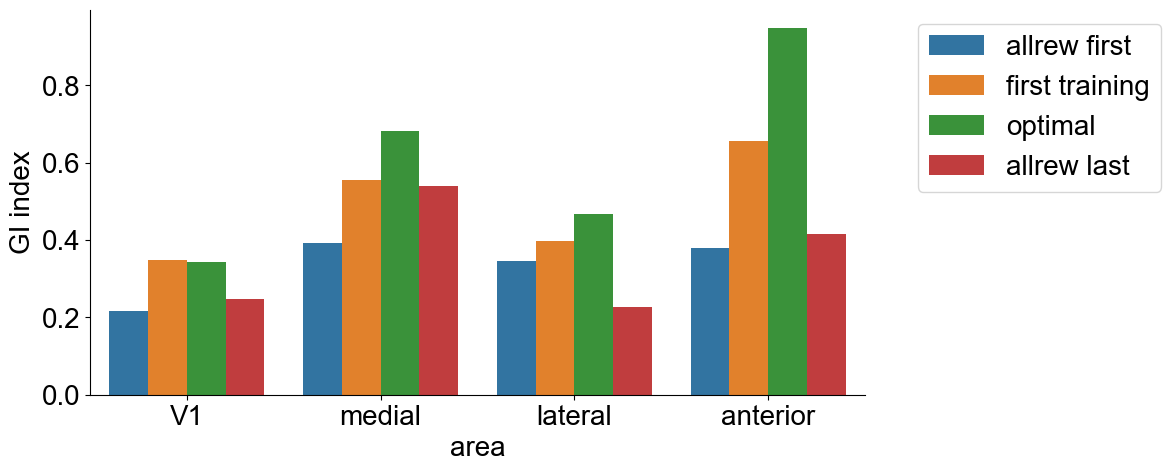

In [468]:
# plot the distribution of GI index for each day and area
plt.figure(figsize=(10,5))
sns.barplot(data=gis_df, x='area', y='GI', hue='day')
plt.ylabel('GI index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()